# Simple Sequence Classification using Adaptor

This notebook demonstrates a simple, single-objective training pipelines using Adaptor. You will see how easy it is to exchange one objective for another, when, e.g. you want to experiment with both (i) traditional and (ii) generative models.

This notebook contains the following parts:

1. Training of Sequence Classification model
2. Training of Generative model
3. Evaluation


In [ ]:
!pip install matplotlib datasets adaptor==0.2.1

## 1. Training of Sequence Classification model

Remember, Transformer-based language models map Sequence classification to a token classification of `[CLS]` or `<s>`.

![image.jpg](https://www.researchgate.net/profile/Juan-Pablo-Usuga-Cadavid/publication/353419108/figure/fig1/AS:1052388236476416@1627920316521/Example-of-a-trained-BERT-for-text-classification_W640.jpg)

[[image source]](https://www.researchgate.net/publication/353419108_Using_deep_learning_to_value_free-form_text_data_for_predictive_maintenance)

1. In this settings, when we **train** or update the model to maximise the chance of predicting correct catePrediction using 'gaussalgo/xlm-roberta-base_CSFD-sk' classifiergory on this single token.

2. During the **inference** (i.e. the actual usage of the model), we look only at model's prediction at this single token. This is also what `transformers.AnyModelForSequenceClassification` does internally.

## Construction of Training pipeline

Below, you will see how to configure training pipeline in Adaptor. In the single-objective training scenarios like this, consider also using vanilla Transformers, such as in the [Sequence Classification tutorial](https://huggingface.co/docs/transformers/tasks/sequence_classification).


#### 2. Training with Adaptor

First we pick the base model. At this point we do not care about the task.

In [ ]:
from adaptor.lang_module import LangModule

language_module = LangModule("xlm-roberta-base")

Second, we choose the objective that we want to fine-tune the model for. The objective will take care of configuring the model correctly. We just give it our desired inputs and outputs.

In [ ]:
from adaptor.objectives.classification import SequenceClassification
from adaptor.evaluators.sequence_classification import SequenceAccuracy

model_quality_evaluator = SequenceAccuracy(decides_convergence=True)

training_objective = SequenceClassification(lang_module=language_module,
                                            texts_or_path=dataset["train"]['comment'],
                                            labels_or_path=dataset["train"]["rating_int"],
                                            val_texts_or_path=dataset["validation"]['comment'],
                                            val_labels_or_path=dataset["validation"]["rating_int"],
                                            val_evaluators=[model_quality_evaluator],
                                            batch_size=4)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

The training process is configured through a possibly large set of arguments. Adaptor works with all arguments of HuggingFace's [TrainingArguments](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments).

In [ ]:
from adaptor.utils import AdaptationArguments, StoppingStrategy

args = AdaptationArguments(output_dir="./output_dir",
                           learning_rate=2e-5,
                           warmup_steps=1000,
                           stopping_strategy=StoppingStrategy.FIRST_OBJECTIVE_CONVERGED,
                           do_train=True,
                           do_eval=True,
                           log_level="critical",
                           logging_steps=100,
                           eval_steps=200,
                           evaluation_strategy="steps",
                           save_steps=200,
                           save_total_limit=6,
                           stopping_patience=5,
                           num_train_epochs=20,
                           gradient_accumulation_steps=8)

Adaptor allows training for multiple objectives at once, that are applied in a chosen Schedule. Multi-objective training is useful for more complex scenarios, but for our case, we suffice with a single objective, so a selection of Schedule does not really matter.

In [ ]:
from adaptor.schedules import SequentialSchedule
from adaptor.adapter import Adapter

parallel_schedule = SequentialSchedule(objectives=[training_objective], args=args)

adapter = Adapter(lang_module=language_module,
                  schedule=parallel_schedule,
                  args=args)

Total number of train samples: 25000
Total number of eval samples: 2500


After all the configuration, we are ready to run the training and wait for the trained model.

Given the `stopping_strategy=StoppingStrategy.FIRST_OBJECTIVE_CONVERGED` and `stopping_patience=1`, the training will terminate after first evaluation, where `model_quality_evaluator` (i.e. `SequenceAccuracy`) does not improve over one evaluation.

In [ ]:
adapter.train()

/home/jovyan/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Converged objectives: []
SequenceClassification:  13%|█▎        | 802/6250 [01:15<09:14,  9.83batches/s, epoch=1, loss=1.79, split=train]

{'loss': 1.8057, 'learning_rate': 2.0000000000000003e-06, 'train_SequenceClassification_loss': 1.8056869113445282, 'train_SequenceClassification_num_batches': 800, 'epoch': 0.01}


SequenceClassification:  26%|██▌       | 1600/6250 [02:41<07:26, 10.41batches/s, epoch=1, loss=1.89, split=train]Converged objectives: []
Evaluating...


{'loss': 1.7941, 'learning_rate': 4.000000000000001e-06, 'train_SequenceClassification_loss': 1.7950378651618957, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.01}


SequenceClassification: 100%|█████████▉| 624/625 [00:18<00:00, 35.98batches/s, epoch=1, loss=-1, split=eval]Converged objectives: []


{'eval_loss': 1.7883870601654053, 'eval_runtime': 20.3519, 'eval_samples_per_second': 30.71, 'eval_steps_per_second': 30.71, 'eval_SequenceClassification_loss': 1.7883872732162476, 'eval_SequenceClassification_num_batches': 625, 'eval_SequenceClassification_SequenceAccuracy': 0.1964, 'epoch': 0.01}


SequenceClassification:  38%|███▊      | 2402/6250 [04:55<06:49,  9.40batches/s, epoch=1, loss=1.71, split=train]

{'loss': 1.771, 'learning_rate': 6e-06, 'train_SequenceClassification_loss': 1.7740453741550446, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.02}


SequenceClassification:  51%|█████     | 3199/6250 [06:21<04:57, 10.25batches/s, epoch=1, loss=1.39, split=train] Converged objectives: []
Evaluating...


{'loss': 1.6261, 'learning_rate': 8.000000000000001e-06, 'train_SequenceClassification_loss': 1.649385324239731, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.03}


SequenceClassification: 100%|█████████▉| 622/625 [00:18<00:00, 35.54batches/s, epoch=1, loss=-1, split=eval]Converged objectives: []


{'eval_loss': 1.5000486373901367, 'eval_runtime': 20.167, 'eval_samples_per_second': 30.991, 'eval_steps_per_second': 30.991, 'eval_SequenceClassification_loss': 1.6442179903507232, 'eval_SequenceClassification_num_batches': 1250, 'eval_SequenceClassification_SequenceAccuracy': 0.356, 'epoch': 0.03}


SequenceClassification:  64%|██████▍   | 4001/6250 [08:36<04:08,  9.04batches/s, epoch=1, loss=1.44, split=train]

{'loss': 1.4952, 'learning_rate': 1e-05, 'train_SequenceClassification_loss': 1.5068887263536452, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.03}


SequenceClassification:  77%|███████▋  | 4800/6250 [09:56<01:26, 16.79batches/s, epoch=1, loss=1.82, split=train] Converged objectives: []
Evaluating...


{'loss': 1.4331, 'learning_rate': 1.2e-05, 'train_SequenceClassification_loss': 1.4371108202934264, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.04}


SequenceClassification: 100%|█████████▉| 624/625 [00:19<00:00, 36.85batches/s, epoch=1, loss=-1, split=eval]rain]Converged objectives: []


{'eval_loss': 1.3178272247314453, 'eval_runtime': 10.5531, 'eval_samples_per_second': 59.224, 'eval_steps_per_second': 59.224, 'eval_SequenceClassification_loss': 1.5354210516452789, 'eval_SequenceClassification_num_batches': 1875, 'eval_SequenceClassification_SequenceAccuracy': 0.4364, 'epoch': 0.04}


SequenceClassification:  90%|████████▉ | 5603/6250 [12:01<01:05,  9.83batches/s, epoch=1, loss=1.04, split=train]

{'loss': 1.3826, 'learning_rate': 1.4e-05, 'train_SequenceClassification_loss': 1.3834207997322083, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.04}


SequenceClassification:   2%|▏         | 149/6250 [00:15<09:12, 11.04batches/s, epoch=2, loss=0.803, split=train]Converged objectives: []
Evaluating...


{'loss': 1.3303, 'learning_rate': 1.6000000000000003e-05, 'train_SequenceClassification_loss': 1.3414764949083329, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.05}


SequenceClassification: 100%|█████████▉| 624/625 [00:18<00:00, 36.04batches/s, epoch=2, loss=-1, split=eval]Converged objectives: []


{'eval_loss': 1.2793632745742798, 'eval_runtime': 20.3154, 'eval_samples_per_second': 30.765, 'eval_steps_per_second': 30.765, 'eval_SequenceClassification_loss': 1.471406610417366, 'eval_SequenceClassification_num_batches': 2500, 'eval_SequenceClassification_SequenceAccuracy': 0.4548, 'epoch': 0.05}


SequenceClassification:  15%|█▌        | 952/6250 [02:27<08:23, 10.52batches/s, epoch=2, loss=1.24, split=train]

{'loss': 1.3165, 'learning_rate': 1.8e-05, 'train_SequenceClassification_loss': 1.3210068408548832, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.06}


SequenceClassification:  28%|██▊       | 1749/6250 [03:55<07:10, 10.46batches/s, epoch=2, loss=0.829, split=train]Converged objectives: []
Evaluating...


{'loss': 1.2726, 'learning_rate': 2e-05, 'train_SequenceClassification_loss': 1.277403223991394, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.06}


SequenceClassification: 100%|█████████▉| 624/625 [00:19<00:00, 37.23batches/s, epoch=2, loss=-1, split=eval]Converged objectives: []


{'eval_loss': 1.256230115890503, 'eval_runtime': 19.9682, 'eval_samples_per_second': 31.3, 'eval_steps_per_second': 31.3, 'eval_SequenceClassification_loss': 1.428371317024231, 'eval_SequenceClassification_num_batches': 3125, 'eval_SequenceClassification_SequenceAccuracy': 0.444, 'epoch': 0.06}


SequenceClassification:  41%|████      | 2552/6250 [05:33<04:01, 15.31batches/s, epoch=2, loss=1.76, split=train]

{'loss': 1.2568, 'learning_rate': 1.9993579454253612e-05, 'train_SequenceClassification_loss': 1.2581012021899223, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.07}


SequenceClassification:  54%|█████▎    | 3350/6250 [06:24<02:48, 17.22batches/s, epoch=2, loss=0.779, split=train]Converged objectives: []
Evaluating...


{'loss': 1.2173, 'learning_rate': 1.9987158908507226e-05, 'train_SequenceClassification_loss': 1.2179782185554504, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.08}


SequenceClassification:  99%|█████████▉| 618/625 [00:09<00:00, 69.43batches/s, epoch=2, loss=-1, split=eval]rain] Converged objectives: []


{'eval_loss': 1.1869587898254395, 'eval_runtime': 10.5805, 'eval_samples_per_second': 59.071, 'eval_steps_per_second': 59.071, 'eval_SequenceClassification_loss': 1.3881358908136685, 'eval_SequenceClassification_num_batches': 3750, 'eval_SequenceClassification_SequenceAccuracy': 0.5168, 'epoch': 0.08}


SequenceClassification:  66%|██████▋   | 4154/6250 [07:44<01:49, 19.13batches/s, epoch=2, loss=1.21, split=train] 

{'loss': 1.1949, 'learning_rate': 1.9980738362760837e-05, 'train_SequenceClassification_loss': 1.1925911034345626, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.08}


SequenceClassification:  79%|███████▉  | 4948/6250 [08:35<01:25, 15.27batches/s, epoch=2, loss=0.822, split=train]Converged objectives: []
Evaluating...


{'loss': 1.1322, 'learning_rate': 1.9974317817014448e-05, 'train_SequenceClassification_loss': 1.128819655776024, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.09}


SequenceClassification:  99%|█████████▉| 618/625 [00:09<00:00, 69.44batches/s, epoch=2, loss=-1, split=eval]rain] Converged objectives: []


{'eval_loss': 1.1504303216934204, 'eval_runtime': 10.5734, 'eval_samples_per_second': 59.111, 'eval_steps_per_second': 59.111, 'eval_SequenceClassification_loss': 1.3541779587779725, 'eval_SequenceClassification_num_batches': 4375, 'eval_SequenceClassification_SequenceAccuracy': 0.5268, 'epoch': 0.09}


SequenceClassification:  92%|█████████▏| 5752/6250 [09:53<00:35, 14.06batches/s, epoch=2, loss=0.567, split=train]

{'loss': 1.1184, 'learning_rate': 1.996789727126806e-05, 'train_SequenceClassification_loss': 1.1163887090831994, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.1}


SequenceClassification:   5%|▍         | 299/6250 [00:18<06:58, 14.21batches/s, epoch=3, loss=0.815, split=train]Converged objectives: []
Evaluating...


{'loss': 1.0957, 'learning_rate': 1.9961476725521673e-05, 'train_SequenceClassification_loss': 1.0892368990331889, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.1}


SequenceClassification:  99%|█████████▉| 618/625 [00:09<00:00, 69.18batches/s, epoch=3, loss=-1, split=eval]ain] Converged objectives: []


{'eval_loss': 1.0905945301055908, 'eval_runtime': 10.5584, 'eval_samples_per_second': 59.195, 'eval_steps_per_second': 59.195, 'eval_SequenceClassification_loss': 1.3212300370931624, 'eval_SequenceClassification_num_batches': 5000, 'eval_SequenceClassification_SequenceAccuracy': 0.5508, 'epoch': 0.1}


SequenceClassification:  18%|█▊        | 1103/6250 [01:35<05:59, 14.30batches/s, epoch=3, loss=0.781, split=train]

{'loss': 1.0702, 'learning_rate': 1.9955056179775283e-05, 'train_SequenceClassification_loss': 1.0723766617029906, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.11}


SequenceClassification:  30%|███       | 1899/6250 [02:23<05:11, 13.98batches/s, epoch=3, loss=0.99, split=train] Converged objectives: []
Evaluating...


{'loss': 1.0789, 'learning_rate': 1.9948635634028894e-05, 'train_SequenceClassification_loss': 1.073704716950655, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.12}


SequenceClassification:  99%|█████████▉| 618/625 [00:09<00:00, 69.91batches/s, epoch=3, loss=-1, split=eval]rain]Converged objectives: []


{'eval_loss': 1.0545318126678467, 'eval_runtime': 10.5456, 'eval_samples_per_second': 59.267, 'eval_steps_per_second': 59.267, 'eval_SequenceClassification_loss': 1.2915969106515248, 'eval_SequenceClassification_num_batches': 5625, 'eval_SequenceClassification_SequenceAccuracy': 0.5744, 'epoch': 0.12}


SequenceClassification:  43%|████▎     | 2702/6250 [03:43<03:57, 14.94batches/s, epoch=3, loss=0.69, split=train] 

{'loss': 1.0297, 'learning_rate': 1.9942215088282505e-05, 'train_SequenceClassification_loss': 1.047823493182659, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.12}


SequenceClassification:  56%|█████▌    | 3499/6250 [04:50<04:40,  9.81batches/s, epoch=3, loss=1, split=train]    Converged objectives: []
Evaluating...


{'loss': 1.03, 'learning_rate': 1.993579454253612e-05, 'train_SequenceClassification_loss': 1.0191282953172922, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.13}


SequenceClassification: 100%|██████████| 625/625 [00:17<00:00, 40.04batches/s, epoch=3, loss=-1, split=eval]Converged objectives: []


{'eval_loss': 1.034177541732788, 'eval_runtime': 18.1862, 'eval_samples_per_second': 34.367, 'eval_steps_per_second': 34.367, 'eval_SequenceClassification_loss': 1.265854975129366, 'eval_SequenceClassification_num_batches': 6250, 'eval_SequenceClassification_SequenceAccuracy': 0.5808, 'epoch': 0.13}


SequenceClassification:  69%|██████▉   | 4302/6250 [06:55<04:04,  7.97batches/s, epoch=3, loss=1.12, split=train] 

{'loss': 0.9672, 'learning_rate': 1.992937399678973e-05, 'train_SequenceClassification_loss': 0.9752445418387652, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.13}


SequenceClassification:  82%|████████▏ | 5100/6250 [08:17<01:27, 13.09batches/s, epoch=3, loss=0.711, split=train]Converged objectives: []
Evaluating...


{'loss': 0.9491, 'learning_rate': 1.992295345104334e-05, 'train_SequenceClassification_loss': 0.9467247564047575, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.14}


SequenceClassification: 100%|█████████▉| 624/625 [00:16<00:00, 40.60batches/s, epoch=3, loss=-1, split=eval]Converged objectives: []


{'eval_loss': 1.0453429222106934, 'eval_runtime': 17.8016, 'eval_samples_per_second': 35.109, 'eval_steps_per_second': 35.109, 'eval_SequenceClassification_loss': 1.245808419204842, 'eval_SequenceClassification_num_batches': 6875, 'eval_SequenceClassification_SequenceAccuracy': 0.5732, 'epoch': 0.14}


SequenceClassification:  94%|█████████▍| 5903/6250 [10:20<00:31, 11.17batches/s, epoch=3, loss=0.591, split=train]

{'loss': 0.9317, 'learning_rate': 1.991653290529695e-05, 'train_SequenceClassification_loss': 0.9310446998402476, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.15}


SequenceClassification:   7%|▋         | 449/6250 [00:44<09:11, 10.52batches/s, epoch=4, loss=1.24, split=train]  Converged objectives: []
Evaluating...


{'loss': 0.9136, 'learning_rate': 1.9910112359550565e-05, 'train_SequenceClassification_loss': 0.9135694723203778, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.15}


SequenceClassification: 100%|█████████▉| 624/625 [00:17<00:00, 39.50batches/s, epoch=4, loss=-1, split=eval]Converged objectives: []


{'eval_loss': 1.0503120422363281, 'eval_runtime': 18.6407, 'eval_samples_per_second': 33.529, 'eval_steps_per_second': 33.529, 'eval_SequenceClassification_loss': 1.2295170531610649, 'eval_SequenceClassification_num_batches': 7500, 'eval_SequenceClassification_SequenceAccuracy': 0.5776, 'epoch': 0.15}


SequenceClassification:  20%|██        | 1253/6250 [02:50<08:54,  9.34batches/s, epoch=4, loss=1.07, split=train]

{'loss': 0.9005, 'learning_rate': 1.9903691813804176e-05, 'train_SequenceClassification_loss': 0.906367786437273, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.16}


SequenceClassification:  33%|███▎      | 2049/6250 [04:12<06:17, 11.14batches/s, epoch=4, loss=0.559, split=train]Converged objectives: []
Evaluating...


{'loss': 0.9216, 'learning_rate': 1.9897271268057787e-05, 'train_SequenceClassification_loss': 0.9126941991522908, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.17}


SequenceClassification: 100%|██████████| 625/625 [00:17<00:00, 35.13batches/s, epoch=4, loss=-1, split=eval]Converged objectives: []


{'eval_loss': 1.088841438293457, 'eval_runtime': 18.7421, 'eval_samples_per_second': 33.347, 'eval_steps_per_second': 33.347, 'eval_SequenceClassification_loss': 1.2186958487639061, 'eval_SequenceClassification_num_batches': 8125, 'eval_SequenceClassification_SequenceAccuracy': 0.5748, 'epoch': 0.17}


SequenceClassification:  46%|████▌     | 2851/6250 [06:19<06:15,  9.05batches/s, epoch=4, loss=0.762, split=train]

{'loss': 0.8983, 'learning_rate': 1.9890850722311397e-05, 'train_SequenceClassification_loss': 0.8973047889471054, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.17}


SequenceClassification:  58%|█████▊    | 3650/6250 [07:36<04:18, 10.06batches/s, epoch=4, loss=1.81, split=train]  Converged objectives: []
Evaluating...


{'loss': 0.8727, 'learning_rate': 1.988443017656501e-05, 'train_SequenceClassification_loss': 0.8773357503265142, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.18}


SequenceClassification: 100%|█████████▉| 622/625 [00:14<00:00, 44.36batches/s, epoch=4, loss=-1, split=eval]Converged objectives: []


{'eval_loss': 1.164727807044983, 'eval_runtime': 16.0588, 'eval_samples_per_second': 38.919, 'eval_steps_per_second': 38.919, 'eval_SequenceClassification_loss': 1.2148409901802029, 'eval_SequenceClassification_num_batches': 8750, 'eval_SequenceClassification_SequenceAccuracy': 0.5696, 'epoch': 0.18}


SequenceClassification:  71%|███████   | 4453/6250 [09:28<03:00,  9.96batches/s, epoch=4, loss=0.296, split=train]

{'loss': 0.8894, 'learning_rate': 1.9878009630818622e-05, 'train_SequenceClassification_loss': 0.886393307954073, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.19}


SequenceClassification:  84%|████████▍ | 5249/6250 [10:49<01:28, 11.31batches/s, epoch=4, loss=0.807, split=train] Converged objectives: []
Evaluating...


{'loss': 0.81, 'learning_rate': 1.9871589085072233e-05, 'train_SequenceClassification_loss': 0.838916339289397, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.19}


SequenceClassification: 100%|█████████▉| 622/625 [00:17<00:00, 37.40batches/s, epoch=4, loss=-1, split=eval]Converged objectives: []


{'eval_loss': 1.0787484645843506, 'eval_runtime': 18.479, 'eval_samples_per_second': 33.822, 'eval_steps_per_second': 33.822, 'eval_SequenceClassification_loss': 1.20576815628767, 'eval_SequenceClassification_num_batches': 9375, 'eval_SequenceClassification_SequenceAccuracy': 0.5832, 'epoch': 0.19}


SequenceClassification:  97%|█████████▋| 6052/6250 [12:52<00:20,  9.56batches/s, epoch=4, loss=0.714, split=train]

{'loss': 0.7877, 'learning_rate': 1.9865168539325844e-05, 'train_SequenceClassification_loss': 0.7906617993675172, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.2}


SequenceClassification:  10%|▉         | 600/6250 [01:00<09:44,  9.67batches/s, epoch=5, loss=0.193, split=train] Converged objectives: []
Evaluating...


{'loss': 0.788, 'learning_rate': 1.9858747993579458e-05, 'train_SequenceClassification_loss': 0.7754975991696119, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.2}


SequenceClassification: 100%|█████████▉| 624/625 [00:17<00:00, 40.49batches/s, epoch=5, loss=-1, split=eval]Converged objectives: []


{'eval_loss': 1.0855845212936401, 'eval_runtime': 18.6592, 'eval_samples_per_second': 33.496, 'eval_steps_per_second': 33.496, 'eval_SequenceClassification_loss': 1.1982566833805293, 'eval_SequenceClassification_num_batches': 10000, 'eval_SequenceClassification_SequenceAccuracy': 0.6012, 'epoch': 0.2}


SequenceClassification:  22%|██▏       | 1403/6250 [03:05<06:57, 11.61batches/s, epoch=5, loss=0.517, split=train]

{'loss': 0.7722, 'learning_rate': 1.985232744783307e-05, 'train_SequenceClassification_loss': 0.7749191367141902, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.21}


SequenceClassification:  35%|███▌      | 2200/6250 [04:28<08:15,  8.18batches/s, epoch=5, loss=0.863, split=train] Converged objectives: []
Evaluating...


{'loss': 0.8283, 'learning_rate': 1.984590690208668e-05, 'train_SequenceClassification_loss': 0.8308469288982451, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.22}


SequenceClassification: 100%|██████████| 625/625 [00:17<00:00, 42.15batches/s, epoch=5, loss=-1, split=eval]Converged objectives: []


{'eval_loss': 1.1354830265045166, 'eval_runtime': 18.3611, 'eval_samples_per_second': 34.039, 'eval_steps_per_second': 34.039, 'eval_SequenceClassification_loss': 1.1574501658227294, 'eval_SequenceClassification_num_batches': 10000, 'eval_SequenceClassification_SequenceAccuracy': 0.5692, 'epoch': 0.22}


SequenceClassification:  48%|████▊     | 3003/6250 [06:35<05:25,  9.99batches/s, epoch=5, loss=0.654, split=train]

{'loss': 0.8034, 'learning_rate': 1.983948635634029e-05, 'train_SequenceClassification_loss': 0.7967601801268757, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.22}


SequenceClassification:  61%|██████    | 3799/6250 [07:56<04:20,  9.40batches/s, epoch=5, loss=0.569, split=train] Converged objectives: []
Evaluating...


{'loss': 0.7657, 'learning_rate': 1.98330658105939e-05, 'train_SequenceClassification_loss': 0.787080108102411, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.23}


SequenceClassification: 100%|██████████| 625/625 [00:17<00:00, 40.83batches/s, epoch=5, loss=-1, split=eval]Converged objectives: []


{'eval_loss': 1.1050034761428833, 'eval_runtime': 18.7841, 'eval_samples_per_second': 33.273, 'eval_steps_per_second': 33.273, 'eval_SequenceClassification_loss': 1.1327598391219973, 'eval_SequenceClassification_num_batches': 10000, 'eval_SequenceClassification_SequenceAccuracy': 0.5924, 'epoch': 0.23}


SequenceClassification:  74%|███████▎  | 4602/6250 [09:59<02:11, 12.49batches/s, epoch=5, loss=0.623, split=train]

{'loss': 0.7677, 'learning_rate': 1.982664526484751e-05, 'train_SequenceClassification_loss': 0.7652335932441056, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.24}


SequenceClassification:  86%|████████▋ | 5400/6250 [11:04<00:48, 17.44batches/s, epoch=5, loss=0.762, split=train] Converged objectives: []
Evaluating...


{'loss': 0.6952, 'learning_rate': 1.9820224719101126e-05, 'train_SequenceClassification_loss': 0.7126810678839683, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.24}


SequenceClassification: 100%|█████████▉| 622/625 [00:17<00:00, 41.27batches/s, epoch=5, loss=-1, split=eval]Converged objectives: []


{'eval_loss': 1.1131144762039185, 'eval_runtime': 18.355, 'eval_samples_per_second': 34.051, 'eval_steps_per_second': 34.051, 'eval_SequenceClassification_loss': 1.1199652938313782, 'eval_SequenceClassification_num_batches': 10000, 'eval_SequenceClassification_SequenceAccuracy': 0.5916, 'epoch': 0.24}


SequenceClassification:  99%|█████████▉| 6203/6250 [13:07<00:04, 10.05batches/s, epoch=5, loss=0.512, split=train]

{'loss': 0.6894, 'learning_rate': 1.9813804173354736e-05, 'train_SequenceClassification_loss': 0.6986253183111548, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.25}


SequenceClassification:  12%|█▏        | 749/6250 [01:14<09:55,  9.24batches/s, epoch=6, loss=0.74, split=train]  Converged objectives: []
Evaluating...


{'loss': 0.6872, 'learning_rate': 1.9807383627608347e-05, 'train_SequenceClassification_loss': 0.6885251641608775, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.26}


SequenceClassification: 100%|██████████| 625/625 [00:18<00:00, 38.55batches/s, epoch=6, loss=-1, split=eval]Converged objectives: []


{'eval_loss': 1.1804156303405762, 'eval_runtime': 18.6061, 'eval_samples_per_second': 33.591, 'eval_steps_per_second': 33.591, 'eval_SequenceClassification_loss': 1.1137810640845447, 'eval_SequenceClassification_num_batches': 10000, 'eval_SequenceClassification_SequenceAccuracy': 0.5896, 'epoch': 0.26}


SequenceClassification:  25%|██▍       | 1552/6250 [03:22<09:45,  8.03batches/s, epoch=6, loss=0.819, split=train]

{'loss': 0.6924, 'learning_rate': 1.9800963081861958e-05, 'train_SequenceClassification_loss': 0.6893863456472754, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.26}


SequenceClassification:  38%|███▊      | 2349/6250 [04:43<07:33,  8.59batches/s, epoch=6, loss=0.66, split=train]  Converged objectives: []
Evaluating...


{'loss': 0.686, 'learning_rate': 1.9794542536115572e-05, 'train_SequenceClassification_loss': 0.7037654118854553, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.27}


SequenceClassification: 100%|█████████▉| 624/625 [00:17<00:00, 42.28batches/s, epoch=6, loss=-1, split=eval]Objective `SequenceClassification` convergence metric `SequenceAccuracy` did not improve for 5 eval steps. History: [0.5692, 0.5924, 0.5916, 0.5896, 0.5532]
Converged objectives: ['SequenceClassification']
Scheduler reached a termination condition: FIRST_OBJECTIVE_CONVERGED


{'eval_loss': 1.3328857421875, 'eval_runtime': 18.5229, 'eval_samples_per_second': 33.742, 'eval_steps_per_second': 33.742, 'eval_SequenceClassification_loss': 1.1185720396701246, 'eval_SequenceClassification_num_batches': 10000, 'eval_SequenceClassification_SequenceAccuracy': 0.5532, 'epoch': 0.27}


Objective `SequenceClassification` convergence metric `SequenceAccuracy` did not improve for 5 eval steps. History: [0.5692, 0.5924, 0.5916, 0.5896, 0.5532]
Converged objectives: ['SequenceClassification']
Scheduler reached a termination condition: FIRST_OBJECTIVE_CONVERGED


{'train_runtime': 3983.5237, 'train_samples_per_second': 627.585, 'train_steps_per_second': 78.448, 'train_loss': 1.0587789444696336, 'train_SequenceClassification_loss': 0.7037654118854553, 'train_SequenceClassification_num_batches': 1000, 'epoch': 0.27}


TrainOutput(global_step=4200, training_loss=1.0587789444696336, metrics={'train_runtime': 3983.5237, 'train_samples_per_second': 627.585, 'train_steps_per_second': 78.448, 'total_flos': 0.0, 'train_loss': 1.0587789444696336})

#### Evaluations report

We'll briefly take a look at the dynamics of the training process.

We see that in our case, evaluation loss is more reliable early-stopping criterion than classfication accuracy.

<Axes: >

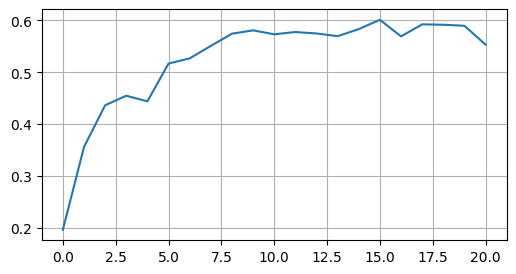

In [ ]:
# Evaluation Accuracy

import pandas as pd

pd.Series(training_objective.evaluations_history["eval"][model_quality_evaluator]).plot(figsize=(6, 3), grid=True)

<Axes: >

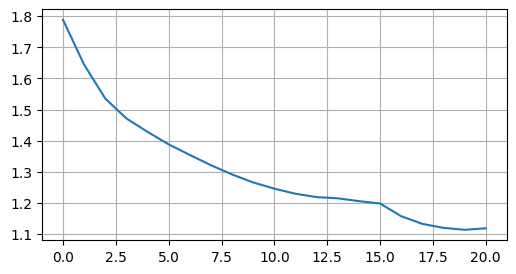

In [ ]:
# Evaluation loss
pd.Series(training_objective.evaluations_history["eval"]["loss"]).plot(figsize=(6, 3), grid=True)

<Axes: >

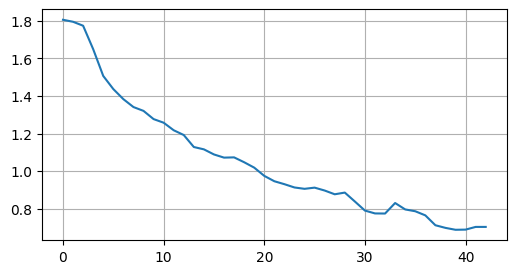

In [ ]:
# Training loss
pd.Series(training_objective.evaluations_history["train"]["loss"]).plot(figsize=(6, 3), grid=True)

## 7. Training of Generative model

Interestingly, generation is just a special case of token classification: In each prediction step, out of all possible tokens in the model vocabulary, we want to pick the one that best fits the input and previously-generated text.


1. In this settings, when we train the model, we update it maximise the chance of predicting correct category on this single token.

2. During the inference (i.e. the actual usage of the model), the model conditions next token prediction based on both (i) input text, and  (ii) it's previously-generated text.

Notice, that in `adaptor`, **the whole training setup for generation is identical to sequence classification above**, thanks to the objective-centric design of experiments.

The only things that change are the base model and training objective: we exchange `SequenceClassification` objective for `Sequence2Sequence`.

In [ ]:
!pip install sentencepiece protobuf==3.20.0  # extra dependences required for generation

In [ ]:
from adaptor.lang_module import LangModule

language_module = LangModule("google/mt5-base")

/home/jovyan/.local/lib/python3.8/site-packages/transformers/convert_slow_tokenizer.py:434: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Second, we choose the objective that we want to fine-tune the model for. The objective will take care of configuring the model correctly. We just give it our desired inputs and outputs.

In [ ]:
from adaptor.objectives.seq2seq import Sequence2Sequence

promt = " Kolko hviezdičiek si zaslúži táto recenzia? Možnosti: 1, 2, 3, 4, 5."

# note that we also have a myriad of Generative Evaluators in Adaptor, 
# but for simplicity, we only use eval loss as early-stopping criterion in this tutorial
# Evaluators can be found in adaptor.evaluators.generative, and used identically to SequenceClassification

training_objective = Sequence2Sequence(lang_module=language_module,
                                       texts_or_path=[promt + review for review in dataset["train"]['comment']],
                                       labels_or_path=[str(x) for x in dataset["train"]["rating_int"]],
                                       val_texts_or_path=[promt + review for review in dataset["validation"]['comment']],
                                       val_labels_or_path=[str(x) for x in dataset["validation"]["rating_int"]],
                                       batch_size=1)

The training process is configured through a possibly large set of arugments. You can read through each of them in [TrainingArgs documentation](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments).

In [ ]:
from adaptor.utils import AdaptationArguments, StoppingStrategy

args = AdaptationArguments(output_dir="./output_dir_generative",
                           learning_rate=2e-5,
                           warmup_steps=1000,
                           stopping_strategy=StoppingStrategy.FIRST_OBJECTIVE_CONVERGED,
                           do_train=True,
                           do_eval=True,
                           log_level="critical",
                           logging_steps=100,
                           eval_steps=200,
                           evaluation_strategy="steps",
                           save_steps=200,
                           save_total_limit=11,
                           stopping_patience=10,
                           num_train_epochs=20,
                           gradient_accumulation_steps=32)

Adaptor allows training for multiple objectives at once, that are applied in a chosen Schedule. Multi-objective training is useful for more complex scenarios, but for our case, we suffice with a single objective, so a selection of Schedule does not really matter.

In [ ]:
from adaptor.schedules import SequentialSchedule
from adaptor.adapter import Adapter

parallel_schedule = SequentialSchedule(objectives=[training_objective], args=args)

adapter = Adapter(lang_module=language_module,
                  schedule=parallel_schedule,
                  args=args)

Total number of train samples: 25000
Total number of eval samples: 2500


After all the configuration, we are ready to run the training and wait for the trained model.

Given the `stopping_strategy=StoppingStrategy.FIRST_OBJECTIVE_CONVERGED` and `stopping_patience=1`, the training will terminate after first evaluation, where `model_quality_evaluator` (i.e. `SequenceAccuracy`) does not improve over one evaluation.

In [ ]:
adapter.train()

/home/jovyan/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Converged objectives: []
Sequence2Sequence:  13%|█▎        | 3202/25000 [07:04<53:40,  6.77batches/s, epoch=1, loss=17, split=train]    

{'loss': 17.9087, 'learning_rate': 2.0000000000000003e-06, 'train_Sequence2Sequence_loss': 16.13142704963684, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.01}


Sequence2Sequence:  26%|██▌       | 6400/25000 [13:55<36:35,  8.47batches/s, epoch=1, loss=17, split=train]    Converged objectives: []
Evaluating...


{'loss': 17.1405, 'learning_rate': 4.000000000000001e-06, 'train_Sequence2Sequence_loss': 17.9901912689209, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.01}


Sequence2Sequence: 100%|█████████▉| 2499/2500 [01:25<00:00, 27.76batches/s, epoch=1, loss=16.1, split=eval]Converged objectives: []


{'eval_loss': 13.747293472290039, 'eval_runtime': 85.0848, 'eval_samples_per_second': 29.382, 'eval_steps_per_second': 29.382, 'eval_Sequence2Sequence_loss': 13.888874187469483, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.01}


Sequence2Sequence:  38%|███▊      | 9602/25000 [22:30<40:07,  6.40batches/s, epoch=1, loss=17.7, split=train]

{'loss': 15.2123, 'learning_rate': 6e-06, 'train_Sequence2Sequence_loss': 13.12563066482544, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.02}


Sequence2Sequence:  51%|█████     | 12800/25000 [29:24<23:46,  8.55batches/s, epoch=1, loss=9.41, split=train]  Converged objectives: []
Evaluating...


{'loss': 13.1265, 'learning_rate': 8.000000000000001e-06, 'train_Sequence2Sequence_loss': 11.312626147270203, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.03}


Sequence2Sequence: 100%|█████████▉| 2498/2500 [01:29<00:00, 27.67batches/s, epoch=1, loss=7.91, split=eval]Converged objectives: []


{'eval_loss': 9.292762756347656, 'eval_runtime': 89.5283, 'eval_samples_per_second': 27.924, 'eval_steps_per_second': 27.924, 'eval_Sequence2Sequence_loss': 9.237446851730347, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.03}


Sequence2Sequence:  64%|██████▍   | 16003/25000 [38:01<19:42,  7.61batches/s, epoch=1, loss=7.07, split=train]

{'loss': 10.1095, 'learning_rate': 1e-05, 'train_Sequence2Sequence_loss': 7.4681835770606995, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.03}


Sequence2Sequence:  77%|███████▋  | 19199/25000 [43:14<08:29, 11.38batches/s, epoch=1, loss=6.23, split=train] Converged objectives: []
Evaluating...


{'loss': 6.9675, 'learning_rate': 1.2e-05, 'train_Sequence2Sequence_loss': 5.620758986473083, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.04}


Sequence2Sequence: 100%|█████████▉| 2498/2500 [01:00<00:00, 42.41batches/s, epoch=1, loss=3.8, split=eval] in]Converged objectives: []


{'eval_loss': 4.800583362579346, 'eval_runtime': 60.8677, 'eval_samples_per_second': 41.073, 'eval_steps_per_second': 41.073, 'eval_Sequence2Sequence_loss': 4.826601564884186, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.04}


Sequence2Sequence:  90%|████████▉ | 22402/25000 [49:40<04:34,  9.46batches/s, epoch=1, loss=0.0848, split=train]

{'loss': 3.6865, 'learning_rate': 1.4e-05, 'train_Sequence2Sequence_loss': 2.250028187036514, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.04}


Sequence2Sequence:   2%|▏         | 600/25000 [01:00<36:15, 11.21batches/s, epoch=2, loss=1.72, split=train]  Converged objectives: []
Evaluating...


{'loss': 1.6736, 'learning_rate': 1.6000000000000003e-05, 'train_Sequence2Sequence_loss': 1.288987749814987, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.05}


Sequence2Sequence: 100%|█████████▉| 2497/2500 [01:00<00:00, 41.67batches/s, epoch=2, loss=0.806, split=eval]Converged objectives: []


{'eval_loss': 0.9550275206565857, 'eval_runtime': 61.0507, 'eval_samples_per_second': 40.95, 'eval_steps_per_second': 40.95, 'eval_Sequence2Sequence_loss': 1.0189049816131592, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.05}


Sequence2Sequence:  15%|█▌        | 3803/25000 [07:30<36:24,  9.70batches/s, epoch=2, loss=0.744, split=train]

{'loss': 1.2113, 'learning_rate': 1.8e-05, 'train_Sequence2Sequence_loss': 0.9597227975726128, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.06}


Sequence2Sequence:  28%|██▊       | 7000/25000 [12:58<38:41,  7.75batches/s, epoch=2, loss=0.829, split=train] Converged objectives: []
Evaluating...


{'loss': 1.0595, 'learning_rate': 2e-05, 'train_Sequence2Sequence_loss': 0.9232580676674843, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.06}


Sequence2Sequence: 100%|█████████▉| 2498/2500 [01:09<00:00, 35.87batches/s, epoch=2, loss=0.687, split=eval]Converged objectives: []


{'eval_loss': 0.8977074027061462, 'eval_runtime': 69.7066, 'eval_samples_per_second': 35.865, 'eval_steps_per_second': 35.865, 'eval_Sequence2Sequence_loss': 0.9306386995315552, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.06}


Sequence2Sequence:  41%|████      | 10203/25000 [20:00<26:15,  9.39batches/s, epoch=2, loss=0.84, split=train] 

{'loss': 1.0496, 'learning_rate': 1.9993579454253612e-05, 'train_Sequence2Sequence_loss': 0.9891065150499344, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.07}


Sequence2Sequence:  54%|█████▎    | 13399/25000 [25:31<25:28,  7.59batches/s, epoch=2, loss=1.2, split=train]   Converged objectives: []
Evaluating...


{'loss': 1.114, 'learning_rate': 1.9987158908507226e-05, 'train_Sequence2Sequence_loss': 1.4632992073893547, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.08}


Sequence2Sequence: 100%|██████████| 2500/2500 [02:21<00:00, 15.79batches/s, epoch=2, loss=0.931, split=eval]Converged objectives: []


{'eval_loss': 0.8781482577323914, 'eval_runtime': 141.1936, 'eval_samples_per_second': 17.706, 'eval_steps_per_second': 17.706, 'eval_Sequence2Sequence_loss': 0.8995459002256393, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.08}


Sequence2Sequence:  66%|██████▋   | 16603/25000 [34:46<12:45, 10.97batches/s, epoch=2, loss=2.86, split=train] 

{'loss': 1.1752, 'learning_rate': 1.9980738362760837e-05, 'train_Sequence2Sequence_loss': 1.0303605556488038, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.08}


Sequence2Sequence:  79%|███████▉  | 19800/25000 [39:56<08:57,  9.68batches/s, epoch=2, loss=0.651, split=train] Converged objectives: []
Evaluating...


{'loss': 1.1018, 'learning_rate': 1.9974317817014448e-05, 'train_Sequence2Sequence_loss': 1.2170063734054566, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.09}


Sequence2Sequence: 100%|█████████▉| 2497/2500 [01:00<00:00, 42.61batches/s, epoch=2, loss=0.777, split=eval]Converged objectives: []


{'eval_loss': 0.9093708992004395, 'eval_runtime': 60.3291, 'eval_samples_per_second': 41.439, 'eval_steps_per_second': 41.439, 'eval_Sequence2Sequence_loss': 0.8524070379137992, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.09}


Sequence2Sequence:  92%|█████████▏| 23002/25000 [46:18<03:07, 10.67batches/s, epoch=2, loss=1.23, split=train]

{'loss': 1.1251, 'learning_rate': 1.996789727126806e-05, 'train_Sequence2Sequence_loss': 0.8924560755491256, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.1}


Sequence2Sequence:   5%|▍         | 1199/25000 [01:55<36:57, 10.73batches/s, epoch=3, loss=1.25, split=train]  Converged objectives: []
Evaluating...


{'loss': 0.9416, 'learning_rate': 1.9961476725521673e-05, 'train_Sequence2Sequence_loss': 0.9576057404279709, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.1}


Sequence2Sequence: 100%|█████████▉| 2499/2500 [01:00<00:00, 42.74batches/s, epoch=3, loss=0.881, split=eval]]Converged objectives: []


{'eval_loss': 0.8875173926353455, 'eval_runtime': 60.2358, 'eval_samples_per_second': 41.504, 'eval_steps_per_second': 41.504, 'eval_Sequence2Sequence_loss': 0.9013218656182289, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.1}


Sequence2Sequence:  18%|█▊        | 4402/25000 [08:20<45:23,  7.56batches/s, epoch=3, loss=0.362, split=train]

{'loss': 0.8777, 'learning_rate': 1.9955056179775283e-05, 'train_Sequence2Sequence_loss': 0.9964094690978527, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.11}


Sequence2Sequence:  30%|███       | 7600/25000 [13:30<28:35, 10.14batches/s, epoch=3, loss=1.48, split=train]  Converged objectives: []
Evaluating...


{'loss': 0.8518, 'learning_rate': 1.9948635634028894e-05, 'train_Sequence2Sequence_loss': 0.98110511302948, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.12}


Sequence2Sequence: 100%|██████████| 2500/2500 [01:00<00:00, 41.94batches/s, epoch=3, loss=0.625, split=eval]]Converged objectives: []


{'eval_loss': 0.7786861062049866, 'eval_runtime': 60.4968, 'eval_samples_per_second': 41.325, 'eval_steps_per_second': 41.325, 'eval_Sequence2Sequence_loss': 0.747508175522089, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.12}


Sequence2Sequence:  43%|████▎     | 10802/25000 [20:13<25:38,  9.23batches/s, epoch=3, loss=1.13, split=train]

{'loss': 0.8176, 'learning_rate': 1.9942215088282505e-05, 'train_Sequence2Sequence_loss': 0.856459392607212, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.12}


Sequence2Sequence:  56%|█████▌    | 13999/25000 [25:21<17:50, 10.28batches/s, epoch=3, loss=0.751, split=train] Converged objectives: []
Evaluating...


{'loss': 0.801, 'learning_rate': 1.993579454253612e-05, 'train_Sequence2Sequence_loss': 0.738645076006651, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.13}


Sequence2Sequence: 100%|█████████▉| 2498/2500 [01:00<00:00, 41.97batches/s, epoch=3, loss=0.66, split=eval]  ] Converged objectives: []


{'eval_loss': 0.6833826899528503, 'eval_runtime': 60.4829, 'eval_samples_per_second': 41.334, 'eval_steps_per_second': 41.334, 'eval_Sequence2Sequence_loss': 0.6239492813497782, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.13}


Sequence2Sequence:  69%|██████▉   | 17203/25000 [31:44<13:49,  9.40batches/s, epoch=3, loss=0.784, split=train]

{'loss': 0.7796, 'learning_rate': 1.992937399678973e-05, 'train_Sequence2Sequence_loss': 0.6439758151769638, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.13}


Sequence2Sequence:  82%|████████▏ | 20399/25000 [36:53<08:32,  8.98batches/s, epoch=3, loss=0.658, split=train] Converged objectives: []
Evaluating...


{'loss': 0.7586, 'learning_rate': 1.992295345104334e-05, 'train_Sequence2Sequence_loss': 0.7579818919301033, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.14}


Sequence2Sequence: 100%|██████████| 2500/2500 [01:00<00:00, 41.53batches/s, epoch=3, loss=0.522, split=eval] Converged objectives: []


{'eval_loss': 0.6365209221839905, 'eval_runtime': 60.4646, 'eval_samples_per_second': 41.347, 'eval_steps_per_second': 41.347, 'eval_Sequence2Sequence_loss': 0.5349153718724847, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.14}


Sequence2Sequence:  94%|█████████▍| 23603/25000 [43:22<02:29,  9.35batches/s, epoch=3, loss=1.02, split=train] 

{'loss': 0.7269, 'learning_rate': 1.991653290529695e-05, 'train_Sequence2Sequence_loss': 0.6378240719437599, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.15}


Sequence2Sequence:   7%|▋         | 1799/25000 [02:52<36:38, 10.55batches/s, epoch=4, loss=1.28, split=train]  Converged objectives: []
Evaluating...


{'loss': 0.7174, 'learning_rate': 1.9910112359550565e-05, 'train_Sequence2Sequence_loss': 0.8308555901050567, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.15}


Sequence2Sequence: 100%|█████████▉| 2496/2500 [01:00<00:00, 42.83batches/s, epoch=4, loss=1.12, split=eval]  ]Converged objectives: []


{'eval_loss': 0.6226826906204224, 'eval_runtime': 60.3031, 'eval_samples_per_second': 41.457, 'eval_steps_per_second': 41.457, 'eval_Sequence2Sequence_loss': 0.5227230403013527, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.15}


Sequence2Sequence:  20%|██        | 5003/25000 [09:37<33:51,  9.84batches/s, epoch=4, loss=0.557, split=train]

{'loss': 0.6995, 'learning_rate': 1.9903691813804176e-05, 'train_Sequence2Sequence_loss': 0.7266338691115379, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.16}


Sequence2Sequence:  33%|███▎      | 8199/25000 [15:16<23:13, 12.05batches/s, epoch=4, loss=0.401, split=train] Converged objectives: []
Evaluating...


{'loss': 0.6957, 'learning_rate': 1.9897271268057787e-05, 'train_Sequence2Sequence_loss': 0.6796964161098004, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.17}


Sequence2Sequence: 100%|█████████▉| 2497/2500 [01:00<00:00, 41.53batches/s, epoch=4, loss=1.04, split=eval]  ]Converged objectives: []


{'eval_loss': 0.5963655114173889, 'eval_runtime': 60.7486, 'eval_samples_per_second': 41.153, 'eval_steps_per_second': 41.153, 'eval_Sequence2Sequence_loss': 0.48524558486416935, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.17}


Sequence2Sequence:  46%|████▌     | 11402/25000 [21:56<24:30,  9.25batches/s, epoch=4, loss=4.58, split=train] 

{'loss': 0.6896, 'learning_rate': 1.9890850722311397e-05, 'train_Sequence2Sequence_loss': 0.6386201687157154, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.17}


Sequence2Sequence:  58%|█████▊    | 14600/25000 [27:10<18:46,  9.23batches/s, epoch=4, loss=1.62, split=train]   Converged objectives: []
Evaluating...


{'loss': 0.6769, 'learning_rate': 1.988443017656501e-05, 'train_Sequence2Sequence_loss': 0.8141349509358407, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.18}


Sequence2Sequence: 100%|█████████▉| 2497/2500 [01:00<00:00, 42.10batches/s, epoch=4, loss=1.07, split=eval]   Converged objectives: []


{'eval_loss': 0.6001282930374146, 'eval_runtime': 60.5808, 'eval_samples_per_second': 41.267, 'eval_steps_per_second': 41.267, 'eval_Sequence2Sequence_loss': 0.487833188418299, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.18}


Sequence2Sequence:  71%|███████   | 17802/25000 [33:40<12:09,  9.87batches/s, epoch=4, loss=0.58, split=train]

{'loss': 0.6756, 'learning_rate': 1.9878009630818622e-05, 'train_Sequence2Sequence_loss': 0.6737121604382992, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.19}


Sequence2Sequence:  84%|████████▍ | 21000/25000 [38:53<06:16, 10.62batches/s, epoch=4, loss=0.306, split=train]  Converged objectives: []
Evaluating...


{'loss': 0.6585, 'learning_rate': 1.9871589085072233e-05, 'train_Sequence2Sequence_loss': 0.6223988311365247, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.19}


Sequence2Sequence: 100%|█████████▉| 2496/2500 [01:00<00:00, 42.18batches/s, epoch=4, loss=0.967, split=eval]  ]Converged objectives: []


{'eval_loss': 0.5861856937408447, 'eval_runtime': 60.5055, 'eval_samples_per_second': 41.319, 'eval_steps_per_second': 41.319, 'eval_Sequence2Sequence_loss': 0.4468530134856701, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.19}


Sequence2Sequence:  97%|█████████▋| 24201/25000 [45:36<01:21,  9.79batches/s, epoch=4, loss=0.277, split=train]

{'loss': 0.6455, 'learning_rate': 1.9865168539325844e-05, 'train_Sequence2Sequence_loss': 0.5100643190555274, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.2}


Sequence2Sequence:  10%|▉         | 2399/25000 [03:54<33:43, 11.17batches/s, epoch=5, loss=0.79, split=train]   Converged objectives: []
Evaluating...


{'loss': 0.6468, 'learning_rate': 1.9858747993579458e-05, 'train_Sequence2Sequence_loss': 0.5149811970070004, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.2}


Sequence2Sequence: 100%|█████████▉| 2498/2500 [00:59<00:00, 41.41batches/s, epoch=5, loss=0.378, split=eval]  Converged objectives: []


{'eval_loss': 0.5601460933685303, 'eval_runtime': 59.788, 'eval_samples_per_second': 41.814, 'eval_steps_per_second': 41.814, 'eval_Sequence2Sequence_loss': 0.4408376425690949, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.2}


Sequence2Sequence:  22%|██▏       | 5603/25000 [10:26<30:39, 10.54batches/s, epoch=5, loss=0.469, split=train]

{'loss': 0.6352, 'learning_rate': 1.985232744783307e-05, 'train_Sequence2Sequence_loss': 0.7465759068727493, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.21}


Sequence2Sequence:  35%|███▌      | 8799/25000 [15:38<27:25,  9.84batches/s, epoch=5, loss=0.0388, split=train] Converged objectives: []
Evaluating...


{'loss': 0.644, 'learning_rate': 1.984590690208668e-05, 'train_Sequence2Sequence_loss': 0.6023554718121886, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.22}


Sequence2Sequence: 100%|█████████▉| 2499/2500 [01:01<00:00, 41.07batches/s, epoch=5, loss=0.714, split=eval]  Converged objectives: []


{'eval_loss': 0.5537274479866028, 'eval_runtime': 61.2439, 'eval_samples_per_second': 40.82, 'eval_steps_per_second': 40.82, 'eval_Sequence2Sequence_loss': 0.42096569160930813, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.22}


Sequence2Sequence:  48%|████▊     | 12002/25000 [22:05<22:23,  9.68batches/s, epoch=5, loss=0.121, split=train]

{'loss': 0.6388, 'learning_rate': 1.983948635634029e-05, 'train_Sequence2Sequence_loss': 0.5808817652985454, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.22}


Sequence2Sequence:  61%|██████    | 15199/25000 [27:25<14:39, 11.14batches/s, epoch=5, loss=0.579, split=train]   Converged objectives: []
Evaluating...


{'loss': 0.6176, 'learning_rate': 1.98330658105939e-05, 'train_Sequence2Sequence_loss': 0.5324886912247166, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.23}


Sequence2Sequence: 100%|█████████▉| 2499/2500 [00:59<00:00, 42.27batches/s, epoch=5, loss=0.723, split=eval]  ]Converged objectives: []


{'eval_loss': 0.5530375838279724, 'eval_runtime': 59.3352, 'eval_samples_per_second': 42.134, 'eval_steps_per_second': 42.134, 'eval_Sequence2Sequence_loss': 0.41948916090419514, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.23}


Sequence2Sequence:  74%|███████▎  | 18402/25000 [33:57<13:39,  8.05batches/s, epoch=5, loss=0.125, split=train]

{'loss': 0.6197, 'learning_rate': 1.982664526484751e-05, 'train_Sequence2Sequence_loss': 0.5873832687211689, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.24}


Sequence2Sequence:  86%|████████▋ | 21600/25000 [39:28<05:25, 10.44batches/s, epoch=5, loss=0.351, split=train]   Converged objectives: []
Evaluating...


{'loss': 0.6004, 'learning_rate': 1.9820224719101126e-05, 'train_Sequence2Sequence_loss': 0.5783053252846002, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.24}


Sequence2Sequence: 100%|██████████| 2500/2500 [00:59<00:00, 42.52batches/s, epoch=5, loss=0.22, split=eval]    Converged objectives: []


{'eval_loss': 0.5415412783622742, 'eval_runtime': 59.261, 'eval_samples_per_second': 42.186, 'eval_steps_per_second': 42.186, 'eval_Sequence2Sequence_loss': 0.3954517652653158, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.24}


Sequence2Sequence:  99%|█████████▉| 24803/25000 [46:15<00:17, 11.22batches/s, epoch=5, loss=0.258, split=train]

{'loss': 0.6034, 'learning_rate': 1.9813804173354736e-05, 'train_Sequence2Sequence_loss': 0.5259017555043102, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.25}


Sequence2Sequence:  12%|█▏        | 2999/25000 [05:04<41:45,  8.78batches/s, epoch=6, loss=0.46, split=train]    Converged objectives: []
Evaluating...


{'loss': 0.6117, 'learning_rate': 1.9807383627608347e-05, 'train_Sequence2Sequence_loss': 0.7263975866138935, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.26}


Sequence2Sequence: 100%|██████████| 2500/2500 [00:59<00:00, 42.34batches/s, epoch=6, loss=0.104, split=eval]  Converged objectives: []


{'eval_loss': 0.5392204523086548, 'eval_runtime': 59.1984, 'eval_samples_per_second': 42.231, 'eval_steps_per_second': 42.231, 'eval_Sequence2Sequence_loss': 0.40796574177918954, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.26}


Sequence2Sequence:  25%|██▍       | 6202/25000 [12:02<29:22, 10.66batches/s, epoch=6, loss=0.315, split=train] 

{'loss': 0.5915, 'learning_rate': 1.9800963081861958e-05, 'train_Sequence2Sequence_loss': 0.5904795465990901, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.26}


Sequence2Sequence:  38%|███▊      | 9400/25000 [17:34<26:13,  9.92batches/s, epoch=6, loss=1.09, split=train]    Converged objectives: []
Evaluating...


{'loss': 0.602, 'learning_rate': 1.9794542536115572e-05, 'train_Sequence2Sequence_loss': 0.5218310073018074, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.27}


Sequence2Sequence: 100%|██████████| 2500/2500 [00:59<00:00, 41.92batches/s, epoch=6, loss=0.0644, split=eval]  Converged objectives: []


{'eval_loss': 0.5270799994468689, 'eval_runtime': 59.729, 'eval_samples_per_second': 41.856, 'eval_steps_per_second': 41.856, 'eval_Sequence2Sequence_loss': 0.3850528732431121, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.27}


Sequence2Sequence:  50%|█████     | 12603/25000 [24:31<20:55,  9.87batches/s, epoch=6, loss=0.919, split=train]

{'loss': 0.6061, 'learning_rate': 1.9788121990369183e-05, 'train_Sequence2Sequence_loss': 0.45653727781027553, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.28}


Sequence2Sequence:  63%|██████▎   | 15800/25000 [30:04<15:23,  9.96batches/s, epoch=6, loss=0.989, split=train]   Converged objectives: []
Evaluating...


{'loss': 0.5984, 'learning_rate': 1.9781701444622793e-05, 'train_Sequence2Sequence_loss': 0.6076782478019596, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.28}


Sequence2Sequence: 100%|█████████▉| 2497/2500 [01:00<00:00, 41.70batches/s, epoch=6, loss=0.976, split=eval]   Converged objectives: []


{'eval_loss': 0.5285273194313049, 'eval_runtime': 60.1461, 'eval_samples_per_second': 41.565, 'eval_steps_per_second': 41.565, 'eval_Sequence2Sequence_loss': 0.3991472888714634, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.28}


Sequence2Sequence:  76%|███████▌  | 19003/25000 [36:59<11:25,  8.74batches/s, epoch=6, loss=0.615, split=train]

{'loss': 0.5773, 'learning_rate': 1.9775280898876404e-05, 'train_Sequence2Sequence_loss': 0.41512585487216713, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.29}


Sequence2Sequence:  89%|████████▉ | 22200/25000 [42:32<04:42,  9.93batches/s, epoch=6, loss=0.782, split=train]   Converged objectives: []
Evaluating...


{'loss': 0.5764, 'learning_rate': 1.9768860353130018e-05, 'train_Sequence2Sequence_loss': 0.4847982835024595, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.29}


Sequence2Sequence: 100%|██████████| 2500/2500 [00:59<00:00, 42.06batches/s, epoch=6, loss=0.0612, split=eval]  Converged objectives: []


{'eval_loss': 0.5239563584327698, 'eval_runtime': 59.3078, 'eval_samples_per_second': 42.153, 'eval_steps_per_second': 42.153, 'eval_Sequence2Sequence_loss': 0.37656585180317054, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.29}


Sequence2Sequence:   2%|▏         | 402/25000 [00:42<55:18,  7.41batches/s, epoch=7, loss=0.277, split=train] 

{'loss': 0.5622, 'learning_rate': 1.976243980738363e-05, 'train_Sequence2Sequence_loss': 0.4356877865735441, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.3}


Sequence2Sequence:  14%|█▍        | 3600/25000 [06:13<34:46, 10.26batches/s, epoch=7, loss=0.668, split=train]  Converged objectives: []
Evaluating...


{'loss': 0.5741, 'learning_rate': 1.975601926163724e-05, 'train_Sequence2Sequence_loss': 0.5757703617215156, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.31}


Sequence2Sequence: 100%|██████████| 2500/2500 [00:59<00:00, 42.57batches/s, epoch=7, loss=0.136, split=eval]   Converged objectives: []


{'eval_loss': 0.5329573154449463, 'eval_runtime': 59.1827, 'eval_samples_per_second': 42.242, 'eval_steps_per_second': 42.242, 'eval_Sequence2Sequence_loss': 0.3857708898675628, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.31}


Sequence2Sequence:  27%|██▋       | 6803/25000 [13:06<35:08,  8.63batches/s, epoch=7, loss=0.269, split=train]

{'loss': 0.5604, 'learning_rate': 1.9749598715890854e-05, 'train_Sequence2Sequence_loss': 0.5301136564346962, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.31}


Sequence2Sequence:  40%|███▉      | 9999/25000 [18:37<23:11, 10.78batches/s, epoch=7, loss=0.533, split=train]  Converged objectives: []
Evaluating...


{'loss': 0.5775, 'learning_rate': 1.9743178170144464e-05, 'train_Sequence2Sequence_loss': 0.7959721550461836, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.32}


Sequence2Sequence: 100%|█████████▉| 2498/2500 [00:59<00:00, 40.64batches/s, epoch=7, loss=0.149, split=eval]   Converged objectives: []


{'eval_loss': 0.5236142873764038, 'eval_runtime': 59.7858, 'eval_samples_per_second': 41.816, 'eval_steps_per_second': 41.816, 'eval_Sequence2Sequence_loss': 0.3973331648739986, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.32}


Sequence2Sequence:  53%|█████▎    | 13202/25000 [25:26<23:50,  8.25batches/s, epoch=7, loss=1.72, split=train]  

{'loss': 0.5611, 'learning_rate': 1.9736757624398075e-05, 'train_Sequence2Sequence_loss': 0.7791984749026597, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.33}


Sequence2Sequence:  66%|██████▌   | 16399/25000 [30:57<13:01, 11.01batches/s, epoch=7, loss=0.605, split=train]   Converged objectives: []
Evaluating...


{'loss': 0.5711, 'learning_rate': 1.9730337078651686e-05, 'train_Sequence2Sequence_loss': 0.6143085643649101, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.33}


Sequence2Sequence: 100%|██████████| 2500/2500 [00:59<00:00, 42.41batches/s, epoch=7, loss=0.0698, split=eval]  Converged objectives: []


{'eval_loss': 0.5071893334388733, 'eval_runtime': 59.3963, 'eval_samples_per_second': 42.09, 'eval_steps_per_second': 42.09, 'eval_Sequence2Sequence_loss': 0.3698523764451966, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.33}


Sequence2Sequence:  78%|███████▊  | 19602/25000 [37:50<09:45,  9.22batches/s, epoch=7, loss=0.145, split=train]

{'loss': 0.5538, 'learning_rate': 1.97239165329053e-05, 'train_Sequence2Sequence_loss': 0.6059135699593753, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.34}


Sequence2Sequence:  91%|█████████ | 22800/25000 [43:30<03:06, 11.80batches/s, epoch=7, loss=1.05, split=train]    Converged objectives: []
Evaluating...


{'loss': 0.5512, 'learning_rate': 1.971749598715891e-05, 'train_Sequence2Sequence_loss': 0.5801600774750113, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.35}


Sequence2Sequence: 100%|█████████▉| 2499/2500 [00:58<00:00, 42.76batches/s, epoch=7, loss=0.732, split=eval]   Converged objectives: []


{'eval_loss': 0.5192049741744995, 'eval_runtime': 58.9591, 'eval_samples_per_second': 42.402, 'eval_steps_per_second': 42.402, 'eval_Sequence2Sequence_loss': 0.38003518845303913, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.35}


Sequence2Sequence:   4%|▍         | 1003/25000 [01:38<41:52,  9.55batches/s, epoch=8, loss=0.878, split=train]

{'loss': 0.5457, 'learning_rate': 1.971107544141252e-05, 'train_Sequence2Sequence_loss': 0.4755964858457446, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.35}


Sequence2Sequence:  17%|█▋        | 4200/25000 [07:08<35:11,  9.85batches/s, epoch=8, loss=1.73, split=train]    Converged objectives: []
Evaluating...


{'loss': 0.5596, 'learning_rate': 1.9704654895666132e-05, 'train_Sequence2Sequence_loss': 0.5862939998507499, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.36}


Sequence2Sequence: 100%|██████████| 2500/2500 [00:59<00:00, 42.30batches/s, epoch=8, loss=0.148, split=eval]   Converged objectives: []


{'eval_loss': 0.5198851227760315, 'eval_runtime': 59.3985, 'eval_samples_per_second': 42.089, 'eval_steps_per_second': 42.089, 'eval_Sequence2Sequence_loss': 0.37279789358435667, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.36}


Sequence2Sequence:  30%|██▉       | 7403/25000 [13:49<30:49,  9.51batches/s, epoch=8, loss=1.71, split=train]  

{'loss': 0.5529, 'learning_rate': 1.9698234349919746e-05, 'train_Sequence2Sequence_loss': 0.33956901472993195, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.36}


Sequence2Sequence:  42%|████▏     | 10600/25000 [19:20<26:04,  9.20batches/s, epoch=8, loss=0.259, split=train]  Converged objectives: []
Evaluating...


{'loss': 0.5615, 'learning_rate': 1.9691813804173357e-05, 'train_Sequence2Sequence_loss': 0.4332905065268278, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.37}


Sequence2Sequence: 100%|█████████▉| 2499/2500 [00:59<00:00, 42.67batches/s, epoch=8, loss=0.715, split=eval]   Converged objectives: []


{'eval_loss': 0.5131158232688904, 'eval_runtime': 59.3613, 'eval_samples_per_second': 42.115, 'eval_steps_per_second': 42.115, 'eval_Sequence2Sequence_loss': 0.37863726761075667, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.37}


Sequence2Sequence:  55%|█████▌    | 13803/25000 [26:04<18:51,  9.90batches/s, epoch=8, loss=1.02, split=train] 

{'loss': 0.547, 'learning_rate': 1.9685393258426968e-05, 'train_Sequence2Sequence_loss': 0.5277315009385347, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.38}


Sequence2Sequence:  68%|██████▊   | 17000/25000 [31:39<13:54,  9.59batches/s, epoch=8, loss=0.573, split=train]   Converged objectives: []
Evaluating...


{'loss': 0.5503, 'learning_rate': 1.967897271268058e-05, 'train_Sequence2Sequence_loss': 0.49954956378787757, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.38}


Sequence2Sequence: 100%|█████████▉| 2499/2500 [00:59<00:00, 42.93batches/s, epoch=8, loss=0.654, split=eval]   Converged objectives: []


{'eval_loss': 0.5158900618553162, 'eval_runtime': 59.3458, 'eval_samples_per_second': 42.126, 'eval_steps_per_second': 42.126, 'eval_Sequence2Sequence_loss': 0.373412733253208, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.38}


Sequence2Sequence:  81%|████████  | 20202/25000 [38:30<08:34,  9.32batches/s, epoch=8, loss=0.479, split=train]

{'loss': 0.5371, 'learning_rate': 1.9672552166934192e-05, 'train_Sequence2Sequence_loss': 0.7105328477453441, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.39}


Sequence2Sequence:  94%|█████████▎| 23399/25000 [43:52<02:43,  9.81batches/s, epoch=8, loss=0.855, split=train]   Converged objectives: []
Evaluating...


{'loss': 0.5349, 'learning_rate': 1.9666131621187803e-05, 'train_Sequence2Sequence_loss': 0.5205264747200999, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.4}


Sequence2Sequence: 100%|██████████| 2500/2500 [00:59<00:00, 43.00batches/s, epoch=8, loss=0.0224, split=eval]  Converged objectives: []


{'eval_loss': 0.5281214714050293, 'eval_runtime': 59.0845, 'eval_samples_per_second': 42.312, 'eval_steps_per_second': 42.312, 'eval_Sequence2Sequence_loss': 0.3893917181767756, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.4}


Sequence2Sequence:   6%|▋         | 1603/25000 [02:44<39:21,  9.91batches/s, epoch=9, loss=0.375, split=train]

{'loss': 0.5409, 'learning_rate': 1.9659711075441414e-05, 'train_Sequence2Sequence_loss': 0.3952503086067736, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.4}


Sequence2Sequence:  19%|█▉        | 4799/25000 [08:11<31:23, 10.72batches/s, epoch=9, loss=0.373, split=train]   Converged objectives: []
Evaluating...


{'loss': 0.5353, 'learning_rate': 1.9653290529695025e-05, 'train_Sequence2Sequence_loss': 0.5716028929455206, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.41}


Sequence2Sequence: 100%|█████████▉| 2498/2500 [00:59<00:00, 42.68batches/s, epoch=9, loss=0.0832, split=eval]  Converged objectives: []


{'eval_loss': 0.5132700204849243, 'eval_runtime': 59.4986, 'eval_samples_per_second': 42.018, 'eval_steps_per_second': 42.018, 'eval_Sequence2Sequence_loss': 0.37770710997865536, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.41}


Sequence2Sequence:  32%|███▏      | 8002/25000 [14:47<25:52, 10.95batches/s, epoch=9, loss=0.424, split=train]

{'loss': 0.533, 'learning_rate': 1.964686998394864e-05, 'train_Sequence2Sequence_loss': 0.6118331732344814, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.42}


Sequence2Sequence:  45%|████▍     | 11199/25000 [20:20<22:54, 10.04batches/s, epoch=9, loss=0.921, split=train]   Converged objectives: []
Evaluating...


{'loss': 0.5387, 'learning_rate': 1.964044943820225e-05, 'train_Sequence2Sequence_loss': 0.60723997905734, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.42}


Sequence2Sequence: 100%|█████████▉| 2499/2500 [00:59<00:00, 42.46batches/s, epoch=9, loss=0.669, split=eval]   ]Converged objectives: []


{'eval_loss': 0.5135796070098877, 'eval_runtime': 59.2113, 'eval_samples_per_second': 42.222, 'eval_steps_per_second': 42.222, 'eval_Sequence2Sequence_loss': 0.37837944358718234, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.42}


Sequence2Sequence:  58%|█████▊    | 14403/25000 [27:06<18:22,  9.61batches/s, epoch=9, loss=1, split=train]    

{'loss': 0.5397, 'learning_rate': 1.963402889245586e-05, 'train_Sequence2Sequence_loss': 0.5801524210721254, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.43}


Sequence2Sequence:  70%|███████   | 17600/25000 [32:35<13:08,  9.38batches/s, epoch=9, loss=1.37, split=train]    Converged objectives: []
Evaluating...


{'loss': 0.5328, 'learning_rate': 1.962760834670947e-05, 'train_Sequence2Sequence_loss': 0.5299173167906701, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.44}


Sequence2Sequence: 100%|██████████| 2500/2500 [00:59<00:00, 41.13batches/s, epoch=9, loss=0.0297, split=eval]  Converged objectives: []


{'eval_loss': 0.5034902691841125, 'eval_runtime': 59.516, 'eval_samples_per_second': 42.006, 'eval_steps_per_second': 42.006, 'eval_Sequence2Sequence_loss': 0.3722729913392686, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.44}


Sequence2Sequence:  83%|████████▎ | 20802/25000 [39:24<07:35,  9.21batches/s, epoch=9, loss=0.0276, split=train]

{'loss': 0.5131, 'learning_rate': 1.9621187800963085e-05, 'train_Sequence2Sequence_loss': 0.5429276508511975, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.44}


Sequence2Sequence:  96%|█████████▌| 24000/25000 [45:03<01:46,  9.35batches/s, epoch=9, loss=0.0665, split=train]  Converged objectives: []
Evaluating...


{'loss': 0.5065, 'learning_rate': 1.9614767255216696e-05, 'train_Sequence2Sequence_loss': 0.5721983339637517, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.45}


Sequence2Sequence: 100%|█████████▉| 2499/2500 [00:59<00:00, 42.47batches/s, epoch=9, loss=0.706, split=eval]   Converged objectives: []


{'eval_loss': 0.5150699019432068, 'eval_runtime': 59.2128, 'eval_samples_per_second': 42.221, 'eval_steps_per_second': 42.221, 'eval_Sequence2Sequence_loss': 0.3666959664868773, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.45}


Sequence2Sequence:   9%|▉         | 2202/25000 [03:51<44:50,  8.47batches/s, epoch=10, loss=1.01, split=train]  

{'loss': 0.5281, 'learning_rate': 1.9608346709470306e-05, 'train_Sequence2Sequence_loss': 0.48698622044175865, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.45}


Sequence2Sequence:  22%|██▏       | 5400/25000 [09:28<31:46, 10.28batches/s, epoch=10, loss=0.706, split=train]   Converged objectives: []
Evaluating...


{'loss': 0.5218, 'learning_rate': 1.960192616372392e-05, 'train_Sequence2Sequence_loss': 0.6729309821268543, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.46}


Sequence2Sequence: 100%|██████████| 2500/2500 [00:59<00:00, 42.91batches/s, epoch=10, loss=0.0379, split=eval]  Converged objectives: []


{'eval_loss': 0.528730571269989, 'eval_runtime': 59.4233, 'eval_samples_per_second': 42.071, 'eval_steps_per_second': 42.071, 'eval_Sequence2Sequence_loss': 0.385827737479558, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.46}


Sequence2Sequence:  34%|███▍      | 8603/25000 [16:17<29:29,  9.27batches/s, epoch=10, loss=0.468, split=train]

{'loss': 0.5162, 'learning_rate': 1.959550561797753e-05, 'train_Sequence2Sequence_loss': 0.4432920694351196, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.47}


Sequence2Sequence:  47%|████▋     | 11799/25000 [21:57<22:18,  9.86batches/s, epoch=10, loss=0.958, split=train]   Converged objectives: []
Evaluating...


{'loss': 0.53, 'learning_rate': 1.9589085072231142e-05, 'train_Sequence2Sequence_loss': 0.6654968202812597, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.47}


Sequence2Sequence: 100%|█████████▉| 2499/2500 [00:59<00:00, 42.25batches/s, epoch=10, loss=0.693, split=eval]   Converged objectives: []


{'eval_loss': 0.5064353346824646, 'eval_runtime': 59.6871, 'eval_samples_per_second': 41.885, 'eval_steps_per_second': 41.885, 'eval_Sequence2Sequence_loss': 0.3757906282806653, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.47}


Sequence2Sequence:  60%|██████    | 15002/25000 [28:47<18:10,  9.17batches/s, epoch=10, loss=1.75, split=train] 

{'loss': 0.5033, 'learning_rate': 1.9582664526484753e-05, 'train_Sequence2Sequence_loss': 0.5067023937823251, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.48}


Sequence2Sequence:  73%|███████▎  | 18199/25000 [34:10<10:35, 10.70batches/s, epoch=10, loss=0.115, split=train]   Converged objectives: []
Evaluating...


{'loss': 0.5146, 'learning_rate': 1.9576243980738367e-05, 'train_Sequence2Sequence_loss': 0.3965223783161491, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.49}


Sequence2Sequence: 100%|██████████| 2500/2500 [00:59<00:00, 42.73batches/s, epoch=10, loss=0.0298, split=eval]  Converged objectives: []


{'eval_loss': 0.5249765515327454, 'eval_runtime': 59.447, 'eval_samples_per_second': 42.054, 'eval_steps_per_second': 42.054, 'eval_Sequence2Sequence_loss': 0.39318603200707003, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.49}


Sequence2Sequence:  86%|████████▌ | 21402/25000 [41:01<06:55,  8.65batches/s, epoch=10, loss=0.0114, split=train]

{'loss': 0.4981, 'learning_rate': 1.9569823434991978e-05, 'train_Sequence2Sequence_loss': 0.4352576333330944, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.49}


Sequence2Sequence:  98%|█████████▊| 24600/25000 [46:40<00:39, 10.12batches/s, epoch=10, loss=0.7, split=train]     Converged objectives: []
Evaluating...


{'loss': 0.5059, 'learning_rate': 1.9563402889245588e-05, 'train_Sequence2Sequence_loss': 0.39349839659407737, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.5}


Sequence2Sequence: 100%|██████████| 2500/2500 [00:59<00:00, 42.86batches/s, epoch=10, loss=0.0244, split=eval]  Converged objectives: []


{'eval_loss': 0.520451545715332, 'eval_runtime': 59.2704, 'eval_samples_per_second': 42.18, 'eval_steps_per_second': 42.18, 'eval_Sequence2Sequence_loss': 0.37552610839542466, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.5}


Sequence2Sequence:  11%|█         | 2802/25000 [04:50<38:48,  9.53batches/s, epoch=11, loss=0.631, split=train]

{'loss': 0.5152, 'learning_rate': 1.95569823434992e-05, 'train_Sequence2Sequence_loss': 0.6208932337845908, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.51}


Sequence2Sequence:  24%|██▍       | 6000/25000 [10:19<29:36, 10.70batches/s, epoch=11, loss=0.0411, split=train]  Converged objectives: []
Evaluating...


{'loss': 0.4941, 'learning_rate': 1.955056179775281e-05, 'train_Sequence2Sequence_loss': 0.3747291999403387, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.51}


Sequence2Sequence: 100%|██████████| 2500/2500 [00:59<00:00, 42.06batches/s, epoch=11, loss=0.0319, split=eval]  Converged objectives: []


{'eval_loss': 0.5053517818450928, 'eval_runtime': 59.5323, 'eval_samples_per_second': 41.994, 'eval_steps_per_second': 41.994, 'eval_Sequence2Sequence_loss': 0.3802253436569299, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.51}


Sequence2Sequence:  37%|███▋      | 9203/25000 [17:06<28:14,  9.32batches/s, epoch=11, loss=0.441, split=train]

{'loss': 0.5151, 'learning_rate': 1.954414125200642e-05, 'train_Sequence2Sequence_loss': 0.913335249107331, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.52}


Sequence2Sequence:  50%|████▉     | 12400/25000 [22:22<20:51, 10.07batches/s, epoch=11, loss=0.573, split=train]   Converged objectives: []
Evaluating...


{'loss': 0.5055, 'learning_rate': 1.953772070626003e-05, 'train_Sequence2Sequence_loss': 0.4158824751153588, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.52}


Sequence2Sequence: 100%|█████████▉| 2499/2500 [00:59<00:00, 42.62batches/s, epoch=11, loss=0.645, split=eval]   Converged objectives: []


{'eval_loss': 0.5081944465637207, 'eval_runtime': 59.1503, 'eval_samples_per_second': 42.265, 'eval_steps_per_second': 42.265, 'eval_Sequence2Sequence_loss': 0.3985707842015108, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.52}


Sequence2Sequence:  62%|██████▏   | 15602/25000 [29:14<17:43,  8.84batches/s, epoch=11, loss=0.0146, split=train]

{'loss': 0.5082, 'learning_rate': 1.9531300160513645e-05, 'train_Sequence2Sequence_loss': 0.32458888047840445, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.53}


Sequence2Sequence:  75%|███████▌  | 18800/25000 [34:52<11:38,  8.88batches/s, epoch=11, loss=0.015, split=train]   Converged objectives: []
Evaluating...


{'loss': 0.4858, 'learning_rate': 1.9524879614767256e-05, 'train_Sequence2Sequence_loss': 0.46332801144453695, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.54}


Sequence2Sequence: 100%|█████████▉| 2499/2500 [00:59<00:00, 42.82batches/s, epoch=11, loss=0.594, split=eval]   Converged objectives: []


{'eval_loss': 0.5175153613090515, 'eval_runtime': 59.2053, 'eval_samples_per_second': 42.226, 'eval_steps_per_second': 42.226, 'eval_Sequence2Sequence_loss': 0.3807108040136154, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.54}


Sequence2Sequence:  88%|████████▊ | 22002/25000 [41:52<06:32,  7.64batches/s, epoch=11, loss=1.56, split=train]  

{'loss': 0.4846, 'learning_rate': 1.9518459069020867e-05, 'train_Sequence2Sequence_loss': 0.5482988751027733, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.54}


Sequence2Sequence:   1%|          | 200/25000 [00:21<44:08,  9.36batches/s, epoch=12, loss=0.343, split=train]   Converged objectives: []
Evaluating...


{'loss': 0.4824, 'learning_rate': 1.9512038523274477e-05, 'train_Sequence2Sequence_loss': 0.47327965890290213, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.55}


Sequence2Sequence: 100%|██████████| 2500/2500 [00:59<00:00, 42.48batches/s, epoch=12, loss=0.0306, split=eval]  Converged objectives: []


{'eval_loss': 0.5046790242195129, 'eval_runtime': 59.3408, 'eval_samples_per_second': 42.129, 'eval_steps_per_second': 42.129, 'eval_Sequence2Sequence_loss': 0.37417812409192264, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.55}


Sequence2Sequence:  14%|█▎        | 3401/25000 [07:07<44:41,  8.06batches/s, epoch=12, loss=0.914, split=train]

{'loss': 0.5018, 'learning_rate': 1.950561797752809e-05, 'train_Sequence2Sequence_loss': 0.4678455790504813, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.56}


Sequence2Sequence:  26%|██▋       | 6600/25000 [12:40<28:40, 10.70batches/s, epoch=12, loss=0.396, split=train]   Converged objectives: []
Evaluating...


{'loss': 0.4929, 'learning_rate': 1.9499197431781702e-05, 'train_Sequence2Sequence_loss': 0.3709556887246436, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.56}


Sequence2Sequence: 100%|█████████▉| 2499/2500 [00:59<00:00, 42.79batches/s, epoch=12, loss=0.713, split=eval]   Converged objectives: []


{'eval_loss': 0.4892161190509796, 'eval_runtime': 59.2241, 'eval_samples_per_second': 42.213, 'eval_steps_per_second': 42.213, 'eval_Sequence2Sequence_loss': 0.3665177660973131, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.56}


Sequence2Sequence:  39%|███▉      | 9803/25000 [19:22<27:52,  9.09batches/s, epoch=12, loss=0.0112, split=train] 

{'loss': 0.5053, 'learning_rate': 1.9492776886035313e-05, 'train_Sequence2Sequence_loss': 0.3760595821891911, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.57}


Sequence2Sequence:  52%|█████▏    | 12999/25000 [24:57<18:18, 10.93batches/s, epoch=12, loss=0.0808, split=train]  Converged objectives: []
Evaluating...


{'loss': 0.4889, 'learning_rate': 1.9486356340288927e-05, 'train_Sequence2Sequence_loss': 0.5273703459650279, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.58}


Sequence2Sequence: 100%|██████████| 2500/2500 [00:59<00:00, 42.75batches/s, epoch=12, loss=0.077, split=eval]   ]Converged objectives: []


{'eval_loss': 0.5077356696128845, 'eval_runtime': 59.1835, 'eval_samples_per_second': 42.242, 'eval_steps_per_second': 42.242, 'eval_Sequence2Sequence_loss': 0.37432838380113026, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.58}


Sequence2Sequence:  65%|██████▍   | 16202/25000 [31:45<17:19,  8.46batches/s, epoch=12, loss=0.708, split=train] 

{'loss': 0.496, 'learning_rate': 1.9479935794542538e-05, 'train_Sequence2Sequence_loss': 0.4600994316395372, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.58}


Sequence2Sequence:  78%|███████▊  | 19400/25000 [37:14<09:30,  9.81batches/s, epoch=12, loss=0.0225, split=train]  Converged objectives: []
Evaluating...


{'loss': 0.4809, 'learning_rate': 1.947351524879615e-05, 'train_Sequence2Sequence_loss': 0.4438044151291251, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.59}


Sequence2Sequence: 100%|██████████| 2500/2500 [00:59<00:00, 42.58batches/s, epoch=12, loss=0.0763, split=eval]   Converged objectives: []


{'eval_loss': 0.5054042339324951, 'eval_runtime': 59.3612, 'eval_samples_per_second': 42.115, 'eval_steps_per_second': 42.115, 'eval_Sequence2Sequence_loss': 0.3638694470819246, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.59}


Sequence2Sequence:  90%|█████████ | 22603/25000 [44:05<04:14,  9.41batches/s, epoch=12, loss=0.146, split=train] 

{'loss': 0.4807, 'learning_rate': 1.946709470304976e-05, 'train_Sequence2Sequence_loss': 0.3785831667264574, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.6}


Sequence2Sequence:   3%|▎         | 800/25000 [01:23<44:40,  9.03batches/s, epoch=13, loss=0.396, split=train]   Converged objectives: []
Evaluating...


{'loss': 0.4737, 'learning_rate': 1.9460674157303373e-05, 'train_Sequence2Sequence_loss': 0.48623442770913244, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.6}


Sequence2Sequence: 100%|█████████▉| 2499/2500 [00:59<00:00, 42.57batches/s, epoch=13, loss=0.553, split=eval]   Converged objectives: []


{'eval_loss': 0.5129628777503967, 'eval_runtime': 59.5483, 'eval_samples_per_second': 41.983, 'eval_steps_per_second': 41.983, 'eval_Sequence2Sequence_loss': 0.3666597532480591, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.6}


Sequence2Sequence:  16%|█▌        | 4003/25000 [08:13<41:39,  8.40batches/s, epoch=13, loss=0.0983, split=train]

{'loss': 0.4954, 'learning_rate': 1.9454253611556984e-05, 'train_Sequence2Sequence_loss': 0.48100812174379826, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.61}


Sequence2Sequence:  29%|██▉       | 7200/25000 [13:44<31:23,  9.45batches/s, epoch=13, loss=0.0375, split=train]  Converged objectives: []
Evaluating...


{'loss': 0.4879, 'learning_rate': 1.9447833065810595e-05, 'train_Sequence2Sequence_loss': 0.4292648277012631, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.61}


Sequence2Sequence: 100%|██████████| 2500/2500 [00:58<00:00, 43.11batches/s, epoch=13, loss=0.0934, split=eval]  Converged objectives: []


{'eval_loss': 0.5119818449020386, 'eval_runtime': 58.8604, 'eval_samples_per_second': 42.473, 'eval_steps_per_second': 42.473, 'eval_Sequence2Sequence_loss': 0.36383356753074625, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.61}


Sequence2Sequence:  42%|████▏     | 10402/25000 [20:40<28:01,  8.68batches/s, epoch=13, loss=0.458, split=train]

{'loss': 0.4861, 'learning_rate': 1.9441412520064206e-05, 'train_Sequence2Sequence_loss': 0.4191356441937387, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.62}


Sequence2Sequence:  54%|█████▍    | 13599/25000 [26:03<18:22, 10.34batches/s, epoch=13, loss=0.528, split=train]   Converged objectives: []
Evaluating...


{'loss': 0.4784, 'learning_rate': 1.943499197431782e-05, 'train_Sequence2Sequence_loss': 0.5468687702901661, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.63}


Sequence2Sequence: 100%|██████████| 2500/2500 [00:59<00:00, 41.96batches/s, epoch=13, loss=0.0733, split=eval]  Converged objectives: []


{'eval_loss': 0.5147397518157959, 'eval_runtime': 59.1669, 'eval_samples_per_second': 42.253, 'eval_steps_per_second': 42.253, 'eval_Sequence2Sequence_loss': 0.3721724234933208, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.63}


Sequence2Sequence:  67%|██████▋   | 16802/25000 [32:58<16:11,  8.44batches/s, epoch=13, loss=0.1, split=train]  

{'loss': 0.4749, 'learning_rate': 1.942857142857143e-05, 'train_Sequence2Sequence_loss': 0.39462841373169794, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.63}


Sequence2Sequence:  80%|████████  | 20000/25000 [38:30<09:06,  9.15batches/s, epoch=13, loss=0.559, split=train]   Converged objectives: []
Evaluating...


{'loss': 0.4779, 'learning_rate': 1.942215088282504e-05, 'train_Sequence2Sequence_loss': 0.3715055366512388, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.64}


Sequence2Sequence: 100%|██████████| 2500/2500 [00:58<00:00, 42.83batches/s, epoch=13, loss=0.0553, split=eval]  Converged objectives: []


{'eval_loss': 0.5091077089309692, 'eval_runtime': 59.0218, 'eval_samples_per_second': 42.357, 'eval_steps_per_second': 42.357, 'eval_Sequence2Sequence_loss': 0.3622108953912175, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.64}


Sequence2Sequence:  93%|█████████▎| 23203/25000 [45:16<03:18,  9.03batches/s, epoch=13, loss=0.58, split=train] 

{'loss': 0.4676, 'learning_rate': 1.9415730337078652e-05, 'train_Sequence2Sequence_loss': 0.5174128056329209, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.65}


Sequence2Sequence:   6%|▌         | 1400/25000 [02:24<38:11, 10.30batches/s, epoch=14, loss=0.0106, split=train]  Converged objectives: []
Evaluating...


{'loss': 0.4614, 'learning_rate': 1.9409309791332266e-05, 'train_Sequence2Sequence_loss': 0.45616555340820925, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.65}


Sequence2Sequence: 100%|██████████| 2500/2500 [00:59<00:00, 42.56batches/s, epoch=14, loss=0.0403, split=eval]  Converged objectives: []


{'eval_loss': 0.5207175612449646, 'eval_runtime': 59.3334, 'eval_samples_per_second': 42.135, 'eval_steps_per_second': 42.135, 'eval_Sequence2Sequence_loss': 0.3794464306027658, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.65}


Sequence2Sequence:  18%|█▊        | 4602/25000 [09:07<39:48,  8.54batches/s, epoch=14, loss=1.32, split=train] 

{'loss': 0.4761, 'learning_rate': 1.9402889245585877e-05, 'train_Sequence2Sequence_loss': 0.27794278897345065, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.66}


Sequence2Sequence:  31%|███       | 7799/25000 [14:36<29:20,  9.77batches/s, epoch=14, loss=0.814, split=train]   Converged objectives: []
Evaluating...


{'loss': 0.4778, 'learning_rate': 1.9396468699839487e-05, 'train_Sequence2Sequence_loss': 0.36681154281977796, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.67}


Sequence2Sequence: 100%|██████████| 2500/2500 [00:59<00:00, 42.60batches/s, epoch=14, loss=0.0429, split=eval]  Converged objectives: []


{'eval_loss': 0.512718141078949, 'eval_runtime': 59.2895, 'eval_samples_per_second': 42.166, 'eval_steps_per_second': 42.166, 'eval_Sequence2Sequence_loss': 0.36688949639614293, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.67}


Sequence2Sequence:  44%|████▍     | 11002/25000 [21:13<22:01, 10.59batches/s, epoch=14, loss=0.0743, split=train]

{'loss': 0.4761, 'learning_rate': 1.9390048154093098e-05, 'train_Sequence2Sequence_loss': 0.3861128713237122, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.67}


Sequence2Sequence:  57%|█████▋    | 14199/25000 [26:48<17:57, 10.03batches/s, epoch=14, loss=0.0322, split=train]  Converged objectives: []
Evaluating...


{'loss': 0.4701, 'learning_rate': 1.9383627608346712e-05, 'train_Sequence2Sequence_loss': 0.5288792096194811, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.68}


Sequence2Sequence: 100%|██████████| 2500/2500 [00:59<00:00, 42.54batches/s, epoch=14, loss=0.0206, split=eval]   Converged objectives: []


{'eval_loss': 0.5064195990562439, 'eval_runtime': 59.2337, 'eval_samples_per_second': 42.206, 'eval_steps_per_second': 42.206, 'eval_Sequence2Sequence_loss': 0.36742951164022086, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.68}


Sequence2Sequence:  70%|██████▉   | 17402/25000 [33:38<13:51,  9.13batches/s, epoch=14, loss=0.00703, split=train]

{'loss': 0.4665, 'learning_rate': 1.9377207062600323e-05, 'train_Sequence2Sequence_loss': 0.5853470032467157, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.68}


Sequence2Sequence:  82%|████████▏ | 20599/25000 [38:50<07:01, 10.44batches/s, epoch=14, loss=0.807, split=train]   Converged objectives: []
Evaluating...


{'loss': 0.4468, 'learning_rate': 1.9370786516853934e-05, 'train_Sequence2Sequence_loss': 0.49325691343983635, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.69}


Sequence2Sequence: 100%|██████████| 2500/2500 [01:01<00:00, 42.44batches/s, epoch=14, loss=0.0286, split=eval]  Converged objectives: []


{'eval_loss': 0.5058165788650513, 'eval_runtime': 61.6052, 'eval_samples_per_second': 40.581, 'eval_steps_per_second': 40.581, 'eval_Sequence2Sequence_loss': 0.36956959562106023, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.69}


Sequence2Sequence:  95%|█████████▌| 23802/25000 [45:23<02:03,  9.73batches/s, epoch=14, loss=0.000817, split=train]

{'loss': 0.4551, 'learning_rate': 1.9364365971107544e-05, 'train_Sequence2Sequence_loss': 0.44054210537287875, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.7}


Sequence2Sequence:   8%|▊         | 2000/25000 [03:26<39:53,  9.61batches/s, epoch=15, loss=0.805, split=train]   Converged objectives: []
Evaluating...


{'loss': 0.4627, 'learning_rate': 1.935794542536116e-05, 'train_Sequence2Sequence_loss': 0.4921399026643485, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.7}


Sequence2Sequence: 100%|█████████▉| 2499/2500 [00:59<00:00, 42.38batches/s, epoch=15, loss=0.669, split=eval]   Converged objectives: []


{'eval_loss': 0.5068882703781128, 'eval_runtime': 59.3718, 'eval_samples_per_second': 42.108, 'eval_steps_per_second': 42.108, 'eval_Sequence2Sequence_loss': 0.3671030857101687, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.7}


Sequence2Sequence:  21%|██        | 5203/25000 [10:17<27:46, 11.88batches/s, epoch=15, loss=0.0023, split=train]

{'loss': 0.4568, 'learning_rate': 1.935152487961477e-05, 'train_Sequence2Sequence_loss': 0.34417617645813153, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.71}


Sequence2Sequence:  34%|███▎      | 8400/25000 [15:46<28:48,  9.60batches/s, epoch=15, loss=0.491, split=train]   Converged objectives: []
Evaluating...


{'loss': 0.4615, 'learning_rate': 1.934510433386838e-05, 'train_Sequence2Sequence_loss': 0.48778395596600604, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.72}


Sequence2Sequence: 100%|█████████▉| 2499/2500 [00:59<00:00, 42.35batches/s, epoch=15, loss=0.7, split=eval]     Converged objectives: []


{'eval_loss': 0.5138648152351379, 'eval_runtime': 59.6039, 'eval_samples_per_second': 41.944, 'eval_steps_per_second': 41.944, 'eval_Sequence2Sequence_loss': 0.37122122727636453, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.72}


Sequence2Sequence:  46%|████▋     | 11602/25000 [22:29<24:38,  9.06batches/s, epoch=15, loss=0.55, split=train] 

{'loss': 0.4811, 'learning_rate': 1.9338683788121994e-05, 'train_Sequence2Sequence_loss': 0.5794610660756007, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.72}


Sequence2Sequence:  59%|█████▉    | 14800/25000 [28:01<17:35,  9.67batches/s, epoch=15, loss=0.00273, split=train] Converged objectives: []
Evaluating...


{'loss': 0.4589, 'learning_rate': 1.9332263242375605e-05, 'train_Sequence2Sequence_loss': 0.4520539697899949, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.73}


Sequence2Sequence: 100%|█████████▉| 2498/2500 [00:58<00:00, 42.01batches/s, epoch=15, loss=0.0395, split=eval]  Converged objectives: []


{'eval_loss': 0.5128594040870667, 'eval_runtime': 58.9628, 'eval_samples_per_second': 42.4, 'eval_steps_per_second': 42.4, 'eval_Sequence2Sequence_loss': 0.38117097136870143, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.73}


Sequence2Sequence:  72%|███████▏  | 18002/25000 [34:51<13:30,  8.63batches/s, epoch=15, loss=0.165, split=train]

{'loss': 0.4612, 'learning_rate': 1.9325842696629215e-05, 'train_Sequence2Sequence_loss': 0.41338120492873714, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.74}


Sequence2Sequence:  85%|████████▍ | 21200/25000 [40:20<05:55, 10.68batches/s, epoch=15, loss=0.319, split=train]   Converged objectives: []
Evaluating...


{'loss': 0.4399, 'learning_rate': 1.9319422150882826e-05, 'train_Sequence2Sequence_loss': 0.47086584819771815, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.74}


Sequence2Sequence: 100%|█████████▉| 2499/2500 [00:59<00:00, 42.93batches/s, epoch=15, loss=0.829, split=eval]   n]Converged objectives: []


{'eval_loss': 0.5155004858970642, 'eval_runtime': 59.1815, 'eval_samples_per_second': 42.243, 'eval_steps_per_second': 42.243, 'eval_Sequence2Sequence_loss': 0.37860950291757034, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.74}


Sequence2Sequence:  98%|█████████▊| 24402/25000 [47:00<01:04,  9.21batches/s, epoch=15, loss=0.385, split=train]

{'loss': 0.4483, 'learning_rate': 1.931300160513644e-05, 'train_Sequence2Sequence_loss': 0.4644367385888472, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.75}


Sequence2Sequence:  10%|█         | 2600/25000 [04:35<40:10,  9.29batches/s, epoch=16, loss=0.259, split=train]   Converged objectives: []
Evaluating...


{'loss': 0.456, 'learning_rate': 1.930658105939005e-05, 'train_Sequence2Sequence_loss': 0.4327113742008805, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.76}


Sequence2Sequence: 100%|█████████▉| 2497/2500 [00:59<00:00, 43.34batches/s, epoch=16, loss=0.756, split=eval]   Converged objectives: []


{'eval_loss': 0.5141530632972717, 'eval_runtime': 59.4825, 'eval_samples_per_second': 42.029, 'eval_steps_per_second': 42.029, 'eval_Sequence2Sequence_loss': 0.3772306936941823, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.76}


Sequence2Sequence:  23%|██▎       | 5803/25000 [11:13<35:00,  9.14batches/s, epoch=16, loss=0.0074, split=train]

{'loss': 0.4478, 'learning_rate': 1.9300160513643662e-05, 'train_Sequence2Sequence_loss': 0.46690354589372873, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.76}


Sequence2Sequence:  36%|███▌      | 8999/25000 [16:42<26:59,  9.88batches/s, epoch=16, loss=0.256, split=train]   Converged objectives: []
Evaluating...


{'loss': 0.4538, 'learning_rate': 1.9293739967897272e-05, 'train_Sequence2Sequence_loss': 0.5165918341255746, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.77}


Sequence2Sequence: 100%|██████████| 2500/2500 [00:59<00:00, 41.30batches/s, epoch=16, loss=0.0375, split=eval]  Objective `Sequence2Sequence` convergence metric `loss` did not improve for 10 eval steps. History: [0.3794464306027658, 0.36688949639614293, 0.36742951164022086, 0.36956959562106023, 0.3671030857101687, 0.37122122727636453, 0.38117097136870143, 0.37860950291757034, 0.3772306936941823, 0.37459440535254546]
Converged objectives: ['Sequence2Sequence']
Scheduler reached a termination condition: FIRST_OBJECTIVE_CONVERGED


{'eval_loss': 0.5148823261260986, 'eval_runtime': 59.5736, 'eval_samples_per_second': 41.965, 'eval_steps_per_second': 41.965, 'eval_Sequence2Sequence_loss': 0.37459440535254546, 'eval_Sequence2Sequence_num_batches': 100, 'epoch': 0.77}


Objective `Sequence2Sequence` convergence metric `loss` did not improve for 10 eval steps. History: [0.3794464306027658, 0.36688949639614293, 0.36742951164022086, 0.36956959562106023, 0.3671030857101687, 0.37122122727636453, 0.38117097136870143, 0.37860950291757034, 0.3772306936941823, 0.37459440535254546]
Converged objectives: ['Sequence2Sequence']
Scheduler reached a termination condition: FIRST_OBJECTIVE_CONVERGED


{'train_runtime': 44469.4849, 'train_samples_per_second': 224.873, 'train_steps_per_second': 7.027, 'train_loss': 1.267830918629964, 'train_Sequence2Sequence_loss': 0.5165918341255746, 'train_Sequence2Sequence_num_batches': 20, 'epoch': 0.77}


TrainOutput(global_step=12000, training_loss=1.267830918629964, metrics={'train_runtime': 44469.4849, 'train_samples_per_second': 224.873, 'train_steps_per_second': 7.027, 'total_flos': 0.0, 'train_loss': 1.267830918629964})

### Training logs

Note that generative approach took much longer to converge: While discriminative training converged in roughly 2 hours, generative approach took almost 12hours. However, mT5-base (600m) is also larger than XLM-RoBERTa-base (110m).

<Axes: >

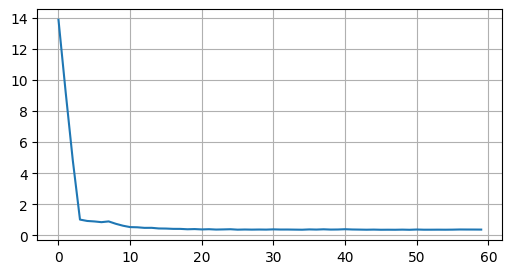

In [ ]:
# Evaluation loss
pd.Series(training_objective.evaluations_history["eval"]["loss"]).plot(figsize=(6, 3), grid=True)

<Axes: >

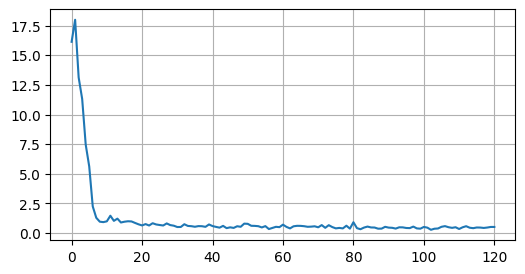

In [ ]:
# Training loss
pd.Series(training_objective.evaluations_history["train"]["loss"]).plot(figsize=(6, 3), grid=True)

## Evaluation

We will take a look whether it's worth to take the **generative** approach, that takes larger model and longer to train, compared to traditional sequence classification.

Below, we evaluate both approaches by loading the training checkpoints where the trainings early-stopped and evaluate them accordingly, for classification accuracy.

Note that, for prediction, we no longer depend on Adaptor: We can use original HuggingFace models, as if we trained with pure `transformers` library. Therefore, no dependency on Adaptor is needed when you deploy the final model.

#### 1. Classification

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# pick the 5-th-last checkpoint (with optimal evaluation accuracy) for the trained objective - note that the specific checkpoint might differ in your setup 
tokenizer = AutoTokenizer.from_pretrained("./train_dir/checkpoint-1600/SequenceClassification")  
classifier = AutoModelForSequenceClassification.from_pretrained("./train_dir/checkpoint-1600/SequenceClassification")

In [ ]:
from tqdm import tqdm

predictions = []

for review, score in tqdm(zip(test_df["comment"].values, test_df["rating_int"].values), total=len(test_df)):
    inputs = tokenizer(review, return_tensors="pt", padding=True, truncation=True)
    outputs = classifier(**inputs)
    output_label_id = outputs.logits.argmax(-1)[0].item()

    prediction = classifier.config.id2label[output_label_id]
    predictions.append(prediction)

100%|██████████| 2500/2500 [18:00<00:00,  2.31it/s]


In [ ]:
true_labels = test_df.rating_int

correct_predictions = sum([pred == true for pred, true in zip(predictions, true_labels)])
incorrect_predictions = sum([pred != true for pred, true in zip(predictions, true_labels)])

accuracy = correct_predictions / (correct_predictions+incorrect_predictions)
average_error = sum(abs(pred - true) for pred, true in zip(predictions, true_labels)) / len(predictions)

print("Prediction using '%s' classifier; accuracy: %s, average error: %s" % (classifier.config.model_type, accuracy, average_error))

Prediction using 'xlm-roberta-base' classifier; accuracy: 0.5736, average error: 0.6412


#### 2. Generation

Evaluation pipeline for generation slightly differs from classification, but the resulting performance is easily comparable.

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# again, pick the 5-th-last checkpoint (with optimal eval loss) for the trained objective - note that the specific checkpoint might differ in your setup 
tokenizer = AutoTokenizer.from_pretrained("./train_dir_generative/checkpoint-3400/Sequence2Sequence")
model = AutoModelForSeq2SeqLM.from_pretrained("./train_dir_generative/checkpoint-3400/Sequence2Sequence")

In [ ]:
from tqdm import tqdm

promt = " Kolko hviezdičiek si zaslúži táto recenzia? Možnosti: 1, 2, 3, 4, 5."

predictions = []
for review in tqdm(test_df["comment"]):
    input_text = promt + review
    inputs = tokenizer(input_text, return_tensors="pt")
    outputs = model.generate(**inputs)
    response_text = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
    predictions.append(response_text)
    
true_labels = test_df.rating_int

  0%|          | 0/2500 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 2500/2500 [40:24<00:00,  1.03it/s]


In [ ]:
correct_predictions = sum([pred == str(true) for pred, true in zip(predictions, true_labels)])
incorrect_predictions = sum([pred != str(true) for pred, true in zip(predictions, true_labels)])

accuracy = correct_predictions / (correct_predictions+incorrect_predictions)
average_error = sum(abs(int(pred) - true) for pred, true in zip(predictions, true_labels)) / len(predictions)

print("Prediction using '%s' classifier; accuracy: %s, average error: %s" % (model.config.model_type, accuracy, average_error))

Prediction using 'mt5' classifier; accuracy: 0.6016, average error: 0.6132


## Conclusions

We have obtained ca. +3% of accuracy, and ca. -3% of absolute error by using the larger generative mt5 model. Perhaps using similarly-large classification model, the gains would be even larger, so the comparison is not perfectly fair, but shows that both traditional and generative approach can perform comparably in the single-objective settings.

Importantly, we have seen that training the model for a completely different approach (classification vs. generation) is fairly simple in Adaptor - you just import a different `Objective` with identical interface and everything else works out-of-box.